# Проект оценка риска ДТП

**Задача проекта:** 
- разработать систему предсказания риска дорожно-транспортных происшествий (ДТП) на основе исторических данных о ДТП в определенном регионе. 

Цель системы — оценивать вероятность ДТП на выбранном маршруте водителя в реальном времени. Когда пользователь бронирует автомобиль, садится за руль и выбирает маршрут, система должна анализировать данный маршрут и предоставлять оценку уровня риска. Если вероятность ДТП высока, система будет предупреждать водителя и предлагать альтернативные маршруты для снижения риска аварии.

Требования Заказчика к алгоритму:  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие.  
- Учесть фактор возраста автомобиля.

**Исходные данные**  

**Общая информация о ДТП** - таблица *collisions*. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.   
**Информация об участниках ДТП** - таблица *parties*. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id.  В данной таблице содержится целевой признак at_fault (виновник).  
**Информация о пострадавших машинах** - таблица *vehicles*. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. 

# Основные этапы проекта:

**План работы**    

1. Загрузка таблиц данных с сервера заказчика.  

2. Первичное исследование таблиц данных.   

3. Статистический анализ факторов ДТП.  

4. Отбор признаков для построения модели. Исследовательский анализ отобранных признаков.  

5. Выбор метрики для оценки модели.

6. Создание моделей для оценки вероятности ДТП. Выбор лучшей модели.  

7. Анализ результатов лучшей модели.  

8. Анализ важности факторов ДТП

9. Выводы и рекомендации.

## Загрузка таблиц данных

In [1]:
!pip install phik -q
!pip install shap -q
!pip install lightgbm
!pip install category_encoders

In [2]:
# Импорт библиотек

import warnings
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats
from phik.report import plot_correlation_matrix
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from warnings import simplefilter

# Импорт Scikit-Learn и других ML-инструментов
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    LabelEncoder, 
    OrdinalEncoder, 
    MinMaxScaler, 
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder


# Импорт моделей машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Метрики и функции оценки
from sklearn.metrics import (
    make_scorer, 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix
)

In [3]:
db_config = {
'user': XXX,
'pwd': XXX,
'host': XXX,
'port': XXX,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

Подключение к базе данных выполнено.

# Первичное исследование таблиц

Проверим наличие таблиц в базе

In [6]:
query = ''' SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';'''

tables_df = pd.read_sql(query, engine)
tables_df

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


## Откроем таблицы и ознакомимся с ними

In [7]:
query = '''
SELECT COUNT(*) as count
FROM case_ids
'''
print('Количество строк в таблице case_ids: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'case_ids'
'''
print('Количество столбцов в таблице case_ids: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM case_ids
LIMIT 10
'''
pd.read_sql(query, engine)

Количество строк в таблице case_ids:  1400000
Количество столбцов в таблице case_ids:  2


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [8]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  10 non-null     object
 1   db_year  10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


Таблица case_ids имеет 2 столбца, 1 400 000 строк, данные заполнены

### vehicles

In [9]:
query = '''
SELECT COUNT(*) as count
FROM vehicles
'''
print('Количество строк в таблице vehicles: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'vehicles'
'''
print('Количество столбцов в таблице vehicles: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM vehicles
LIMIT 10
'''
pd.read_sql(query, engine)

Количество строк в таблице vehicles:  1021234
Количество столбцов в таблице vehicles:  6


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [10]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Таблица vehicles имеет 6 столбцов, 1 021 234 строк, данные заполнены

- 'id' - Номер в таблице
- 'case_id' - Уникальный номер для зарегистрированного происшествия в таблице происшествий.
- 'party_number' - номер участника ДТП
- 'vehicle_type' - Тип кузова
- 'vehicle_transmission' - Тип КПП
- 'vehicle_age' - Возраст автомобиля (в годах)

### parties

In [11]:
query = '''
SELECT COUNT(*) as count
FROM parties
'''
print('Количество строк в таблице parties: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'parties'
'''
print('Количество столбцов в таблице parties: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM parties
LIMIT 10
'''
pd.read_sql(query, engine)

Количество строк в таблице parties:  2752408
Количество столбцов в таблице parties:  9


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [12]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 848.0+ bytes


Таблица parties имеет 9 столбцов, 2 752 408 строк, данные заполнены

- 'case_id' - Идентификационный  номер в базе данных
- 'party_number' - Номер участника происшествия
- 'party_type' - Тип участника происшествия
- 'at_fault' - Виновность участника
- 'insurance_premium' - Сумма страховки (тыс. $)
- 'party_sobriety' - Трезвость участника
- 'party_drug_physical' - Состояние участника: физическое или с учётом принятых лекарств
- 'cellphone_in_use' - Наличие телефона в автомобиле (возможности разговаривать по громкой связи)

### collisions

In [13]:
query = '''
SELECT COUNT(*) as count
FROM collisions
'''
print('Количество строк в таблице collisions: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'collisions'
'''
print('Количество столбцов в таблице collisions: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM collisions
LIMIT 10
'''
pd.read_sql(query, engine)

Количество строк в таблице collisions:  1400000
Количество столбцов в таблице collisions:  20


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [14]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

Таблица parties имеет 20 столбцов, 1 400 000 строк данные заполнены


- 'case_id' - Идентификационный  Номер в базе данных
- 'county_city_location' - Номер географических районов, где произошло ДТП
- 'county_location' - Названия географических районов, где произошло ДТП
- 'distance' - Расстояние от главной дороги (метры)
- 'direction' - Направление движения
- 'intersection' - Является ли место происшествие перекрёстком
- 'weather_1' - Погода
- 'location_type' - Тип дороги
- 'collision_damage' - Серьёзность происшествия
- 'party_count' - Количество участников
- 'primary_collision_factor' - Основной фактор аварии
- 'pcf_violation_category' - Категория нарушения
- 'type_of_collision' - Тип аварии
- 'motor_vehicle_involved_with' - Дополнительные участники ДТП
- 'road_surface' - Состояние дороги
- 'road_condition_1' - Дорожное состояние
- 'lighting' - Освещение
- 'control_device' - Устройство управления
- 'collision_date' - Дата происшествия
- 'collision_time' - Время происшествия

В 2012 году количество ДТП (1 400 000) значительно превышает число зарегистрированных автомобилей участников (1 021 234), что указывает на неполные данные в таблице vehicles. 

Определим, для скольких водителей у нас есть информация и о ДТП, и об их автомобилях, учитывая все требования заказчика.

In [15]:
query = '''
SELECT COUNT(DISTINCT p.id)
FROM parties p
LEFT JOIN collisions c ON c.case_id = p.case_id
LEFT JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE party_type = 'car'
      AND collision_damage <> 'scratch'
      AND EXTRACT(YEAR FROM collision_date::date) = '2012'
      AND v.id IS NOT NULL
      AND p.party_number IS NOT NULL'''
print('Количество водителей с информацией о ДТП и авто: ', pd.read_sql(query, engine)['count'][0])

Количество водителей с информацией о ДТП и авто:  56248


**Вывод**:

Таблицы с данными открыты и просмотрены. Содержание таблиц соответствует описанию данных.

Выяснилось, что в `vehicles` отсутствуют данные по многим ДТП и участникам. Мы проверили, для скольких водителей есть полная информация о ДТП и автомобилях за 2012 год, учитывая требования заказчика. В итоге таких наблюдений — 56 248, что достаточно для исследования.

Общий ключ для всех таблиц - идентификатор ДТП case_id. Кроме того, участники ДТП из таблицы parties связаны со своими транспортными средствами в таблице vehicles сочетанием case_id и party_number (номер участника в рамках конкретного ДТП).

#  Cтатистический анализ факторов ДТП

### Количество ДТП по месяцам

In [16]:
query = '''SELECT case_id, 
                  EXTRACT(MONTH FROM collision_date) AS month
           FROM collisions
           WHERE party_count = '1' '''
collision_date = pd.read_sql(query, engine)
collision_date.head()

,case_id,month
0,4083075,1.0
1,4083116,1.0
2,4083182,1.0
3,4083204,1.0
4,4083369,1.0


In [17]:
# Подсчет количества аварий по месяцам
collision_date['month'].value_counts()

3.0     27677
1.0     26853
2.0     25946
5.0     25586
4.0     25435
12.0    22299
10.0    21787
11.0    20088
6.0     20035
8.0     19974
7.0     19963
9.0     19123
Name: month, dtype: int64

### Построим график

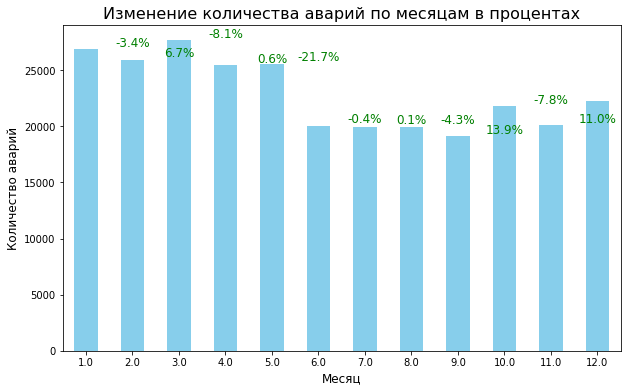

In [18]:
# Подсчет количества аварий по месяцам
month_counts = collision_date['month'].value_counts().sort_index()

# Подсчет изменения в процентах по сравнению с предыдущим месяцем
month_counts_sorted = month_counts.sort_index()  # Сортировка по месяцам
percentage_change = month_counts_sorted.pct_change() * 100  # Вычисление процентного изменения

# Построение графика с изменением количества аварий в процентах
plt.figure(figsize=(10, 6))
bars = month_counts.plot(kind='bar', color='skyblue')

# Добавление заголовков и подписей
plt.title('Изменение количества аварий по месяцам в процентах', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество аварий', fontsize=12)

# Добавление процентных изменений на столбцах
for i, change in enumerate(percentage_change):
    if pd.notna(change): 
        plt.text(i, month_counts[i] + 0.3, f'{change:.1f}%', ha='center', va='bottom', fontsize=12, color='green')


plt.xticks(rotation=0)
plt.show()


### **ВЫВОД**:

Судя по результатам, можно сделать следующие выводы о количестве аварий по месяцам:

- Наибольшее количество аварий происходило в период с января по май, что может быть объяснено погодными условиями, меньшей длительность светового дня.
- Летние и осенние месяцы насчитавают меньшее количество ДТП.
- Резкое снижения количества аварий происходит в июне, возможно, что с началом летнего периода люди переезжают на дачи, дети и студенты прекращают посещать учебные заведения.

### Анализ факторов, влияющих на ДТП

С целью определения наиболее значимых факторов риска ДТП необходимо решить следующие аналитические задачи: 

1. Оценить связь серьезности повреждения транспортного средства и возраста автомобиля
2. Оценить связь между серьезностью повреждения транспортного средства и трезвостью участника ДТП.
3. Оценить связь серьезности повреждения транспортного средства и состояния дорожного покрытия ROAD_SURFACE
4. Определить, что является основным фактором аварии
5. Оценить связь серьезности повреждения транспортного средства и  Наличие телефона в автомобиле (возможности разговаривать по громкой связи)
6. Оценить связь серьезности повреждения транспортного средства и Погодных условий WEATHER_1

#### 1.Оценить связь серьезности повреждения транспортного средства и возраста автомобиля

**Задача:**

Оценить связь между серьезностью повреждения транспортного средства и возрастом автомобиля.

Шаги для выполнения:

1.1. Создать SQL-запрос для получения данных о серьезности повреждения транспортного средства и возрасте автомобиля на основании таблиц collisions_df и vehicles_df. Таблицы связаны по идентифиционному номеру дела (case_id). Запрос должен содержать столбцы collision_damage (серьезность повреждения) и vehicle_age (возраст автомобиля).

1.2. Построить график
1.3. Сделать выводы на основании графика:

Есть ли корреляция между возрастом автомобиля и серьезностью повреждений?
Как изменяется серьезность повреждений в зависимости от возраста автомобиля (например, увеличивается ли повреждение с возрастом)?

In [19]:
# Выполняем SQL-запрос
query = '''SELECT 
    c.case_id, 
    c.collision_damage, 
    v.vehicle_age
FROM collisions c 
JOIN vehicles v ON c.CASE_ID = v.case_id'''
damage_vehicle_age = pd.read_sql(query, engine)
damage_vehicle_age

,case_id,collision_damage,vehicle_age
0,5305162,small damage,8.0
1,4091920,scratch,11.0
2,5305300,small damage,6.0
3,5365340,small damage,3.0
4,5366604,scratch,7.0
...,...,...,...
1021229,5303279,small damage,3.0
1021230,5303775,small damage,4.0
1021231,5304280,small damage,4.0
1021232,5304704,small damage,4.0


In [20]:
print(damage_vehicle_age['collision_damage'].isna().sum())
print(damage_vehicle_age['vehicle_age'].isna().sum())

0
24582


In [21]:
print(damage_vehicle_age['collision_damage'].unique())
print(damage_vehicle_age['vehicle_age'].unique())

['small damage' 'scratch' 'middle damage' 'severe damage' 'fatal']
[  8.  11.   6.   3.   7.   5.   9.   0.   2.   4.  nan   1.  10.  14.
  12.  15.  13.  16.  18.  17.  19. 161.  20.]


Наблюдаем аномальное значение возраста автомобиля, равное 161 году.

Предположим, что 161 - это возраст автомобиля в месяцах. В реальности, нужно было бы уточнить у тех, кто предоставил данные

In [22]:
damage_vehicle_age.loc[damage_vehicle_age['vehicle_age'] == 161, 'vehicle_age'] = 13
print(damage_vehicle_age['vehicle_age'].unique())

[ 8. 11.  6.  3.  7.  5.  9.  0.  2.  4. nan  1. 10. 14. 12. 15. 13. 16.
 18. 17. 19. 20.]


In [23]:
# Подсчитываем количество каждого типа повреждений
damage_counts = damage_vehicle_age['collision_damage'].value_counts()

# Рассчитываем процент для каждого типа повреждений
damage_percent = round(damage_counts / damage_counts.sum() * 100, 2)

# Объединяем количество и проценты в один DataFrame
result = pd.DataFrame({'Count': damage_counts, 'Percentage (%)': damage_percent})
print(result)

                Count  Percentage (%)
scratch        460059           45.05
small damage   283413           27.75
middle damage  221523           21.69
severe damage   41096            4.02
fatal           15143            1.48


**Построим график**

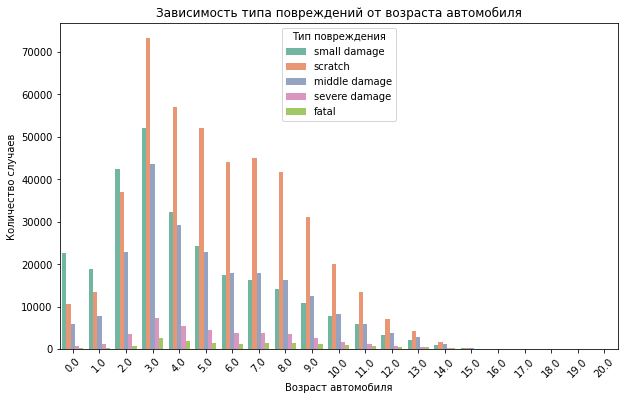

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='vehicle_age', hue='collision_damage', data=damage_vehicle_age, palette='Set2')

# Настройки графика
plt.title('Зависимость типа повреждений от возраста автомобиля')
plt.xlabel('Возраст автомобиля')
plt.ylabel('Количество случаев')
plt.legend(title='Тип повреждения')
plt.xticks(rotation=45)
plt.show()

**Выводы:**
- Большинство столкновений (более 70%) приводят к незначительным повреждениям (царапинам или небольшим повреждениям), что свидетельствует о том, что многие аварии происходят на низкой скорости или в городских условиях.
- Только малый процент аварий (около 2%) приводит к серьезным повреждениям или фатальным последствиям, что показывает, что тяжелые аварии менее часты, но они более разрушительны.


**Автомобили возрастом 3 года часто оказываются в зоне повышенного риска аварий по возможным следующим причинам:**

- Снижение внимательности владельцев: К этому моменту владельцы уже привыкли к машине, что может привести к снижению внимания за рулём. Они становятся более расслабленными и менее осторожными.

- Увеличение пробега: За 3 года автомобиль может набрать значительный пробег, что увеличивает вероятность износа ключевых компонентов (шины, тормоза и т.д.). Это может стать фактором, влияющим на безопасность.

- Смена владельцев: Трёхлетние автомобили часто перепродаются, и новые владельцы могут еще не полностью привыкнуть к управлению, что увеличивает риск аварий.

- Потеря заводских настроек и замены: Некоторые элементы безопасности могут быть заменены или изменены за 3 года эксплуатации (например, фары, тормозные колодки), и их качество может снизиться по сравнению с заводскими оригинальными запчастями.

- Условия эксплуатации: Через 3 года авто может начать больше нуждаться в ремонте и техобслуживании, что тоже может сказываться на его поведении на дороге, если ремонт был некачественным.

#### 2. Оценить связь между серьезностью повреждения транспортного средства и трезвостью участника ДТП.

-  Использовать таблицы collisions и vehicles. В таблице collisions поле collision_damage представляет серьезность повреждений, а в поле sobriety содержится информация о трезвости участников. Оценить связь между серьезностью повреждения транспортного средства и трезвостью участника ДТП. 

- Построить график, который отобразит зависимость между трезвостью участников и серьезностью повреждений.

Можно построить столбчатую диаграмму, где по оси X будет серьезность повреждений, а по оси Y – будут категории трезвости участников.
Построить график зависимости вины в ДТП от уровня трезвости.

- Сделать вывод, основываясь на результатах анализа и графике. Выяснить, как трезвость участников может влиять на степень повреждения транспортных средств в ДТП.

In [25]:
# Выполняем SQL-запрос
query = '''SELECT 
    c.collision_damage, 
    p.party_sobriety,
    p.at_fault
FROM collisions c 
JOIN parties p ON c.CASE_ID = p.case_id'''
damage_soberty = pd.read_sql(query, engine)
damage_soberty

,collision_damage,party_sobriety,at_fault
0,scratch,had not been drinking,1
1,small damage,not applicable,0
2,fatal,had not been drinking,1
3,middle damage,impairment unknown,1
4,small damage,not applicable,0
...,...,...,...
2752403,small damage,had not been drinking,1
2752404,severe damage,had not been drinking,1
2752405,small damage,had not been drinking,1
2752406,middle damage,had not been drinking,1


In [26]:
print(damage_soberty['collision_damage'].isna().sum())
print(damage_soberty['party_sobriety'].isna().sum())

0
73955


Заполним пропуски по столбцу party_sobriety как had not been drinking, сделаем предположение, что раз других данных нет, то человек был трезв

In [27]:
damage_soberty['party_sobriety'] = damage_soberty['party_sobriety'].fillna('had not been drinking')

In [28]:
print(damage_soberty['party_sobriety'].isna().sum())

0


In [29]:
print(damage_soberty['collision_damage'].unique())
print(damage_soberty['party_sobriety'].unique())

['scratch' 'small damage' 'fatal' 'middle damage' 'severe damage']
['had not been drinking' 'not applicable' 'impairment unknown'
 'had been drinking, under influence'
 'had been drinking, impairment unknown'
 'had been drinking, not under influence']


In [30]:
# Группировка по party_sobriety и collision_damage, подсчет количества случаев
summary_table = damage_soberty.groupby(['party_sobriety', 'collision_damage']).size().unstack(fill_value=0)

# Добавляем проценты для каждой строки
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Вывод таблицы с абсолютными значениями
print("Таблица с абсолютными значениями:")
print(summary_table)

Таблица с абсолютными значениями:
collision_damage                        fatal  middle damage  scratch  \
party_sobriety                                                          
had been drinking, impairment unknown     436           2512     3032   
had been drinking, not under influence    368           3167     4443   
had been drinking, under influence       3681          22197    16462   
had not been drinking                   12924         258435   654574   
impairment unknown                       1871          14281    34345   
not applicable                            674          15340    21332   

collision_damage                        severe damage  small damage  
party_sobriety                                                       
had been drinking, impairment unknown            1144         14295  
had been drinking, not under influence            711          8961  
had been drinking, under influence               6101         63972  
had not been drinking          

In [31]:
# Вывод таблицы с процентами
print("\nТаблица с процентами:")
print(summary_table_percent)


Таблица с процентами:
collision_damage                        fatal  middle damage  scratch  \
party_sobriety                                                          
had been drinking, impairment unknown    2.04          11.73    14.16   
had been drinking, not under influence   2.08          17.94    25.17   
had been drinking, under influence       3.27          19.75    14.64   
had not been drinking                    0.59          11.75    29.77   
impairment unknown                       0.80           6.13    14.75   
not applicable                           0.40           9.06    12.60   

collision_damage                        severe damage  small damage  
party_sobriety                                                       
had been drinking, impairment unknown            5.34         66.74  
had been drinking, not under influence           4.03         50.77  
had been drinking, under influence               5.43         56.91  
had not been drinking                     

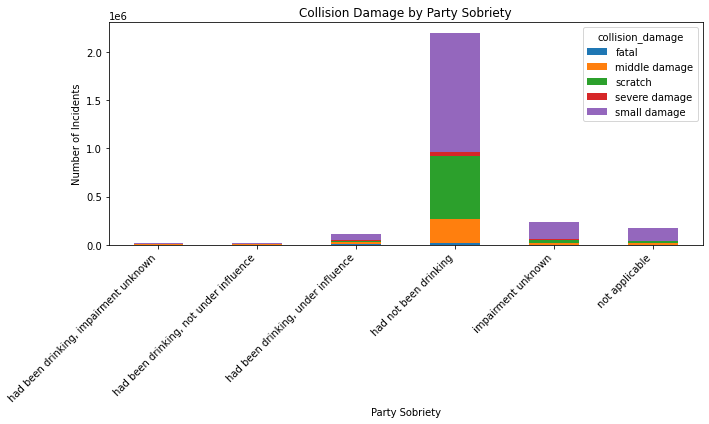

In [32]:
summary_table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Настройка заголовков и подписей
plt.title('Collision Damage by Party Sobriety')
plt.xlabel('Party Sobriety')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha="right")

# Отображение графика
plt.tight_layout()
plt.show()

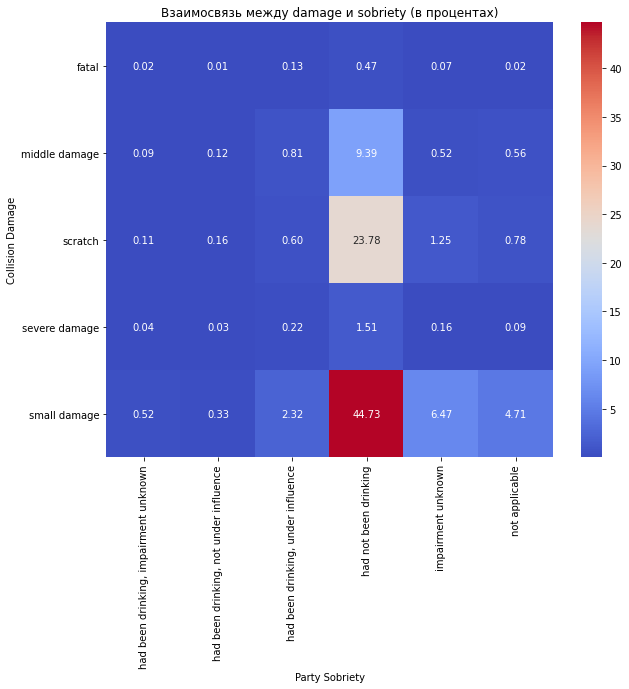

In [33]:
# Подсчитаем количество каждой комбинации значений
pivot_table = pd.crosstab(damage_soberty['collision_damage'], damage_soberty['party_sobriety'])

# Преобразуем значения в проценты
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Построим тепловую карту
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Взаимосвязь между damage и sobriety (в процентах)')
plt.xlabel('Party Sobriety')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

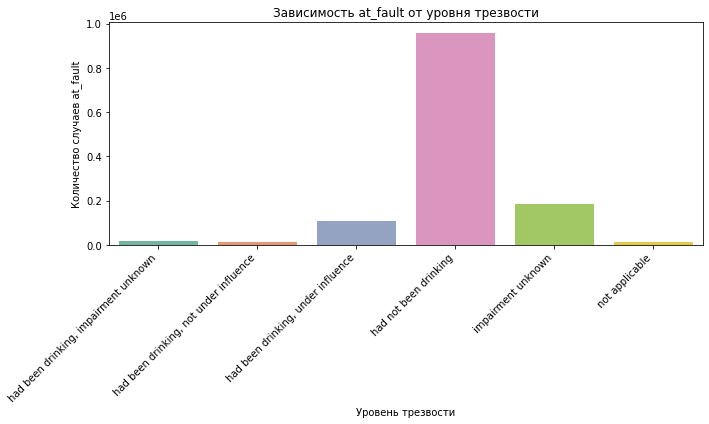

In [34]:
# Группируем данные по уровню трезвости и считаем количество случаев at_fault
sobriety_fault_counts = damage_soberty.groupby('party_sobriety')['at_fault'].sum()

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x=sobriety_fault_counts.index, y=sobriety_fault_counts.values, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество случаев at_fault')
plt.title('Зависимость at_fault от уровня трезвости')
plt.tight_layout()
plt.show()

**ВЫВОД**

**Трезвые участники реже попадают в серьёзные аварии:**

- Несмотря на то, что трезвые участники вовлечены в наибольшее количество аварий, подавляющее большинство этих случаев связано с лёгкими повреждениями или их отсутствием. Только 0.59% аварий с участием трезвых водителей были фатальными, и 1.89% — серьёзными. Это подчёркивает важность вождения в трезвом состоянии для снижения тяжести последствий ДТП.

**Алкоголь значительно увеличивает риск серьёзных аварий:**
- Участники, находящиеся под воздействием алкоголя, демонстрируют существенно больше фатальных и серьёзных аварий. 3.27% фатальных случаев и 5.43% серьёзных повреждений в категории "under influence" подтверждают прямую корреляцию между употреблением алкоголя и риском серьёзных последствий.

**Неопределённость трезвости также опасна:**
- Случаи с неопределённым состоянием трезвости имеют относительно высокий риск серьёзных повреждений (1.88%) и фатальных исходов (0.80%), что подчеркивает важность точной оценки состояния водителя на дороге.


**Заключение:**

Основной вывод из данных заключается в том, что вождение в состоянии алкогольного опьянения или неопределённости трезвости значительно увеличивает риск фатальных аварий и серьёзных повреждений. В то время как трезвые водители чаще остаются участниками мелких инцидентов с минимальными повреждениями, употребление алкоголя существенно повышает вероятность серьёзных последствий.

### Дополнительные задания

#### 3. Оценить связь серьезности повреждения транспортного средства и состояния дорожного покрытия ROAD_SURFACE

-  Использовать таблицу collisions. В таблице collisions поле collision_damage представляет серьезность повреждений, а в поле road_surface содержится информация о состоянии дорожного покрытия. Оценить связь между серьезностью повреждения транспортного средства и состоянием дорожного покрытия. 

- Построить график, который отобразит зависимость между состоянием дорожного покрытия и серьезностью повреждений.

- Сделать вывод, основываясь на результатах анализа и графике. Выяснить, как состояние дорожного покрытия может влиять на степень повреждения транспортных средств в ДТП.

In [35]:
# Выполняем SQL-запрос
query = '''SELECT 
    collision_damage, 
    road_surface
FROM collisions '''
damage_road = pd.read_sql(query, engine)
damage_road

,collision_damage,road_surface
0,small damage,wet
1,small damage,dry
2,scratch,dry
3,scratch,dry
4,scratch,dry
...,...,...
1399995,middle damage,dry
1399996,middle damage,dry
1399997,middle damage,dry
1399998,middle damage,dry


In [36]:
damage_road.isna().sum()

collision_damage        0
road_surface        13093
dtype: int64

In [37]:
damage_road['road_surface'] = damage_road['road_surface'].fillna('not stated')
damage_road['road_surface'].isna().sum()

0

In [38]:
print(damage_road['collision_damage'].unique())
print(damage_road['road_surface'].unique())

['small damage' 'scratch' 'severe damage' 'middle damage' 'fatal']
['wet' 'dry' 'not stated' 'slippery' 'snowy']


In [39]:
# Подсчитываем количество каждого типа покрытия
damage_counts = damage_road['road_surface'].value_counts()

# Рассчитываем процент для каждого типа покрытия
damage_percent = round(damage_counts / damage_counts.sum() * 100, 2)

# Объединяем количество и проценты в один DataFrame
result = pd.DataFrame({'Count': damage_counts, 'Percentage (%)': damage_percent})
print(result)

              Count  Percentage (%)
dry         1242026           88.72
wet          136236            9.73
not stated    13093            0.94
snowy          7261            0.52
slippery       1384            0.10


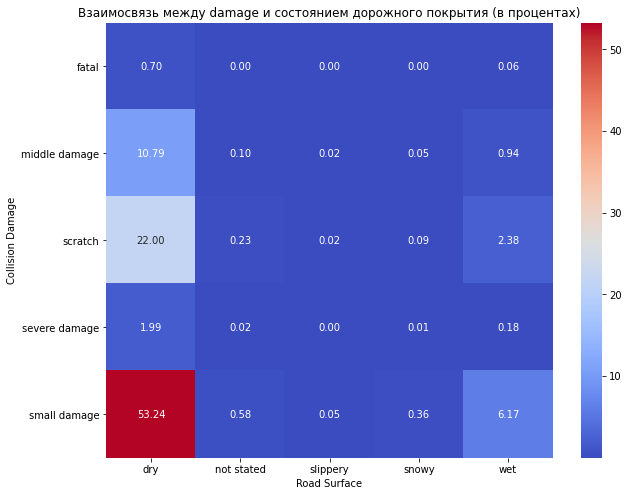

In [40]:
# Подсчитаем количество каждой комбинации значений
pivot_table = pd.crosstab(damage_road['collision_damage'], damage_road['road_surface'])

# Преобразуем значения в проценты
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Построим тепловую карту
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Взаимосвязь между damage и состоянием дорожного покрытия (в процентах)')
plt.xlabel('Road Surface')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**Выводы:**
- Сухие дороги — наиболее распространенное состояние, на котором происходят аварии, что говорит о том, что безопасность водителей не зависит исключительно от состояния покрытия.
- Мокрые и скользкие дороги — потенциально опасные, и даже несмотря на меньшую их распространённость, необходимо учитывать повышенные риски для водителей.
- Снежные и скользкие покрытия приводят к относительно небольшому числу аварий, вероятно, из-за сезонности и условий вождения, которые ограничивают использование дорог.

####  4. Определить, что является основным фактором аварии

 Определить, что является основным фактором аварии
-  Использовать таблицу collisions, поле primary_collision_factor.

- Сделать вывод, основываясь на результатах анализа.

In [41]:
# Выполняем SQL-запрос
query = '''SELECT 
primary_collision_factor
FROM collisions '''
damage_primary_factor = pd.read_sql(query, engine)
damage_primary_factor

,primary_collision_factor
0,vehicle code violation
1,vehicle code violation
2,vehicle code violation
3,vehicle code violation
4,vehicle code violation
...,...
1399995,vehicle code violation
1399996,vehicle code violation
1399997,vehicle code violation
1399998,vehicle code violation


In [42]:
damage_primary_factor['primary_collision_factor'].isna().sum()

8166

In [43]:
damage_primary_factor['primary_collision_factor'].unique()

array(['vehicle code violation', None, 'unknown',
       'other improper driving', 'other than driver', 'fell asleep'],
      dtype=object)

In [44]:
damage_primary_factor['primary_collision_factor'] = damage_primary_factor['primary_collision_factor'].fillna('unknown')

In [45]:
collision_counts = damage_primary_factor['primary_collision_factor'].value_counts()
collision_percentages = round(damage_primary_factor['primary_collision_factor'].value_counts(normalize=True) * 100,2)
collision_df_prim_factor = pd.DataFrame({
    'Count': collision_counts,
    'Percentage (%)': collision_percentages
})
collision_df_prim_factor

,Count,Percentage (%)
vehicle code violation,1316453,94.03
unknown,45180,3.23
other than driver,29780,2.13
other improper driving,8470,0.60
fell asleep,117,0.01


**ВЫВОД**:

- vehicle code violation (нарушение правил ПДД) — 1 316 453 случая (категория A):

Это самая большая категория, на которую приходится подавляющее большинство аварий. Нарушение правил дорожного движения (например, превышение скорости, проезд на красный свет, несоблюдение дистанции) является основной причиной столкновений. Это подчеркивает важность соблюдения ПДД для предотвращения аварий.

- other than driver (кроме водителя) — 29 780 случаев (категория C):

Эти аварии произошли по причинам, не связанным напрямую с водителем (например, внешние обстоятельства, технические неисправности или действия пассажиров). Такие данные показывают, что не все аварии происходят из-за ошибки водителя, а могут быть связаны с внешними факторами.

- other improper driving (другое неправильное вождение) — 8 470 случаев (категория B):

Эта категория включает прочие ошибки водителей, которые не подпадают под стандартные нарушения ПДД. Сюда могут входить действия, такие как неправильное использование полосы движения, опасное маневрирование или иные неявные ошибки водителей.

- fell asleep (заснул) — 117 случаев (категория E):

Засыпание за рулем является редкой, но крайне опасной причиной аварий. Хотя таких случаев немного, они обычно приводят к тяжелым последствиям, подчеркивая важность отдыха для водителей, особенно на дальних расстояниях.


- Основная причина аварий — это нарушения правил ПДД. Для уменьшения количества ДТП требуется усилить контроль и пропаганду соблюдения правил дорожного движения.
- Неопределенные причины (unknown) и внешние факторы (other than driver) также играют значительную роль, что говорит о необходимости более точного сбора данных и учета всех факторов при анализе аварий.
- Хотя количество случаев, когда водители засыпают за рулем, невелико, опасность таких происшествий велика, и меры по предотвращению усталости водителей (например, места для отдыха на трассах) могут снизить их число.

**Общие данные показывают, что основное внимание должно быть направлено на улучшение соблюдения ПДД и на предотвращение усталости за рулем.**

#### 5. Оценить связь серьезности повреждения транспортного средства и  Наличие телефона в автомобиле (возможности разговаривать по громкой связи)

Оценить связь между серьезностью повреждения транспортного средства и наличием телефона в автомобиле (возможностью разговаривать по громкой связи). 

Для этого необходимо:

- Проанализировать данные: Использовать таблицы collisions (поле collision_damage) и vehicles (поле cellphone_in_use) по полю case_id, чтобы выявить возможную корреляцию между серьезностью повреждений и использованием телефона во время движения.

- Составить SQL-запрос: Объединить данные из указанных таблиц с помощью оператора JOIN, чтобы сопоставить информацию о повреждениях и использовании телефона для каждого случая.

- Сделать выводы: На основании полученных результатов определить, существует ли статистически значимая связь между использованием телефона в автомобиле и серьезностью повреждений при столкновениях.

In [46]:
query = '''SELECT c.collision_damage,
                  p.cellphone_in_use
        FROM collisions c
        JOIN parties AS p ON c.case_id = p.case_id'''
damage_cellphone= pd.read_sql(query, engine)

In [47]:
damage_cellphone.head()

,collision_damage,cellphone_in_use
0,scratch,0.0
1,small damage,0.0
2,fatal,NaN
3,middle damage,0.0
4,small damage,NaN


In [48]:
print(damage_cellphone['collision_damage'].isna().sum())
print(damage_cellphone['cellphone_in_use'].unique())

0
[ 0. nan  1.]


In [49]:
damage_cellphone['cellphone_in_use'] = damage_cellphone['cellphone_in_use'].fillna('not stated')
print(damage_cellphone['cellphone_in_use'].unique())

[0.0 'not stated' 1.0]


In [50]:
# Группировка по cellphone_in_use и collision_damage, подсчет количества случаев
summary_table = damage_cellphone.groupby(['cellphone_in_use', 'collision_damage']).size().unstack(fill_value=0)

# Добавляем проценты для каждой строки
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Вывод таблицы с абсолютными значениями
print("Таблица с абсолютными значениями:")
print(summary_table)

Таблица с абсолютными значениями:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
cellphone_in_use                                                            
0.0               16216         253169   594408          45439       1285714
1.0                 321           4736    12318            842         27608
not stated         3417          58027   127462          10054        312677


In [51]:
# Вывод таблицы с процентами
print("\nТаблица с процентами:")
print(summary_table_percent)


Таблица с процентами:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
cellphone_in_use                                                            
0.0                0.74          11.53    27.08           2.07         58.58
1.0                0.70          10.33    26.88           1.84         60.25
not stated         0.67          11.34    24.91           1.97         61.11


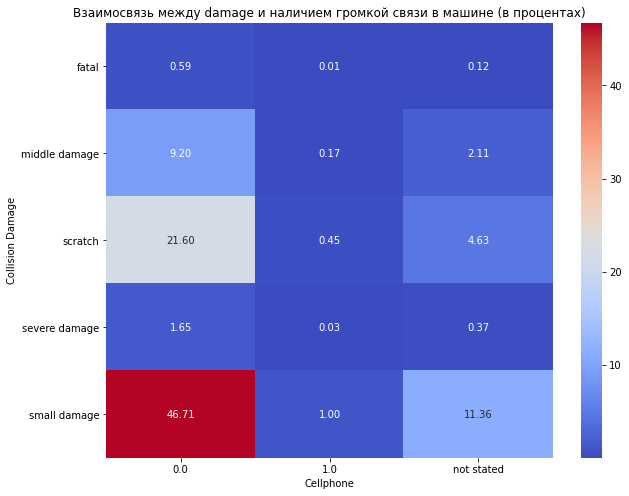

In [52]:
# Подсчитаем количество каждой комбинации значений
pivot_table = pd.crosstab(damage_cellphone['collision_damage'], damage_cellphone['cellphone_in_use'])

# Преобразуем значения в проценты
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Построим тепловую карту
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Взаимосвязь между damage и наличием громкой связи в машине (в процентах)')
plt.xlabel('Cellphone')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**ВЫВОД**:
- Группа без телефона: Большинство аварий (58.58%) связаны с незначительными повреждениями. Смертельные исходы составляют менее 1% (0.74%).
- Группа с телефоном: Несмотря на использование телефона, процентное соотношение видов повреждений аналогично группе без телефона. Самая высокая доля — незначительные повреждения (60.25%), смертельные исходы также около 0.70%.
- Группа "not stated": Процент смертельных исходов (0.67%) почти такой же, как и в других группах. Также преобладают незначительные повреждения (61.11%).


- Вне зависимости от того, использовался ли мобильный телефон, большая часть аварий связана с незначительными повреждениями.
- Доля аварий с серьезными последствиями (смертельные случаи, тяжелые повреждения) не сильно отличается между водителями, использующими телефон, и теми, кто не использует его.
- Информация о мобильном телефоне не всегда влияет на распределение по типам повреждений, что может указывать на другие важные факторы, влияющие на тяжесть аварий.

**Вывод:** хотя использование мобильного телефона во время вождения увеличивает вероятность аварий, его влияние на тип повреждений (особенно на тяжесть) в данных не столь значительно.

#### 6. Оценить связь серьезности повреждения транспортного средства и Погодных условий WEATHER_1

Оценить связь между серьезностью повреждения транспортного средства и погодными условиями.

Для этого необходимо:

- Проанализировать данные: Использовать таблицу collisions (поле collision_damage, поле weather_1), чтобы выявить возможную корреляцию между серьезностью повреждений и погодными условиями.

- Составить SQL-запрос.

- Сделать выводы: На основании полученных результатов определить, существует ли статистически значимая связь между погодными условиями и серьезностью повреждений при столкновениях.

In [53]:
query = '''SELECT collision_damage,
                  weather_1
        FROM collisions'''
damage_weather= pd.read_sql(query, engine)

In [54]:
damage_weather.head()

,collision_damage,weather_1
0,small damage,cloudy
1,small damage,clear
2,scratch,clear
3,scratch,clear
4,scratch,clear


In [55]:
print(damage_weather['weather_1'].isna().sum())
print(damage_weather['weather_1'].unique())

7259
['cloudy' 'clear' 'raining' None 'fog' 'snowing' 'other' 'wind']


In [56]:
damage_weather['weather_1'] = damage_weather['weather_1'].fillna('not stated')
print(damage_weather['weather_1'].isna().sum())
print(damage_weather['weather_1'].unique())

0
['cloudy' 'clear' 'raining' 'not stated' 'fog' 'snowing' 'other' 'wind']


In [57]:
# Группировка по weather_1 и collision_damage, подсчет количества случаев
summary_table = damage_weather.groupby(['weather_1', 'collision_damage']).size().unstack(fill_value=0)

# Добавляем проценты для каждой строки
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Вывод таблицы с абсолютными значениями
print("Таблица с абсолютными значениями:")
print(summary_table)

Таблица с абсолютными значениями:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
weather_1                                                                   
clear              8749         137013   278281          25375        671630
cloudy             1530          22176    49316           3949        126059
fog                 113            715     1219            208          3901
not stated           41            763     1766            140          4549
other                18            114      232             39          1113
raining             328           5528    14754            969         36397
snowing              10            227      431             52          1851
wind                  4             47      107             15           271


In [58]:
# Вывод таблицы с процентами
print("\nТаблица с процентами:")
print(summary_table_percent)


Таблица с процентами:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
weather_1                                                                   
clear              0.78          12.22    24.82           2.26         59.91
cloudy             0.75          10.92    24.29           1.95         62.09
fog                1.84          11.61    19.80           3.38         63.37
not stated         0.56          10.51    24.33           1.93         62.67
other              1.19           7.52    15.30           2.57         73.42
raining            0.57           9.53    25.45           1.67         62.78
snowing            0.39           8.83    16.76           2.02         72.00
wind               0.90          10.59    24.10           3.38         61.04


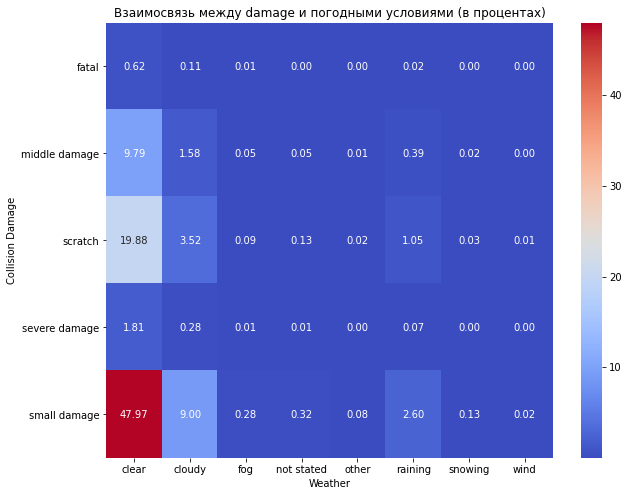

In [59]:
# Подсчитаем количество каждой комбинации значений
pivot_table = pd.crosstab(damage_weather['collision_damage'], damage_weather['weather_1'])

# Преобразуем значения в проценты
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Построим тепловую карту
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Взаимосвязь между damage и погодными условиями (в процентах)')
plt.xlabel('Weather')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**ВЫВОД**:
- Ясная и облачная погода характеризуются самыми низкими процентами летальных исходов и преобладанием небольших повреждений.
- Туман, дождь и ветер приводят к более серьезным последствиям, что выражается в более высоких процентах летальных исходов и серьезных повреждений.
- Снег и туман приводят к более высоким рискам по сравнению с другими погодными условиями, особенно в отношении серьезных аварий.
- Эти данные могут быть полезны для разработки мер по повышению безопасности в зависимости от погодных условий.


# Отбор признаков для построения модели

### Модель по видению заказчика
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник))
- Тип виновника — только машина (car).
- ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Данные только за 2012 год.
- Учтен фактор возраста автомобиля.

Вывод данных

In [60]:
# Выполняем SQL-запрос
query = '''SELECT 
    c.*,
    p.party_number,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
FROM collisions c 
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car' 
  AND c.collision_damage != 'scratch' 
  AND EXTRACT(YEAR FROM c.collision_date) = 2012'''
data_1 = pd.read_sql(query, engine)

In [61]:
data_1.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,collision_time,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,5600885,3607,san bernardino,400.0,north,0.0,clear,None,small damage,2,...,22:04:00,1,1,43.0,had not been drinking,None,0.0,sedan,auto,8.0
1,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,...,02:00:00,2,0,54.0,had not been drinking,None,0.0,sedan,manual,10.0
2,5612888,3026,orange,40.0,north,0.0,clear,None,small damage,2,...,12:50:00,1,1,28.0,had not been drinking,None,0.0,sedan,auto,4.0
3,5613058,1900,los angeles,0.0,None,1.0,clear,None,small damage,2,...,13:04:00,1,1,45.0,had not been drinking,None,0.0,sedan,auto,0.0
4,5613642,0109,alameda,1900.0,west,0.0,clear,highway,small damage,4,...,19:50:00,2,0,20.0,had not been drinking,None,0.0,sedan,auto,0.0


In [62]:
data_1.shape

(56248, 29)

Выведем и оставим только месяц 2012 года

In [63]:
data_1['collision_date'] = pd.to_datetime(data_1['collision_date'], format='%Y-%m-%d')

In [64]:
data_1['collision_month'] = pd.to_datetime(data_1['collision_date']).dt.month
data_1['collision_month'].value_counts()

3     11511
4     10865
1     10789
2     10331
5      9683
6      1308
8       374
9       342
7       327
11      264
10      262
12      192
Name: collision_month, dtype: int64

**ВАЖНЫЙ МОМЕНТ**:
по условиям задачи данные должны быть использованы только за 2012 год.
Стоит обратить внимание, что данные выглядят неполными - за январь-май данных в разы больше, чем за остальные месяцы.
Таким образом, данный показатель не может быть рассмотрен при построении модели

Добавим час ДТП

In [65]:
# Преобразование столбца 'collision_time' в тип данных времени
data_1['collision_time'] = pd.to_datetime(data_1['collision_time'], format='%H:%M:%S')

# Создание нового столбца с часом
data_1['collision_hour'] = data_1['collision_time'].dt.hour
data_1['collision_hour'].value_counts()

15.0    4868
17.0    4250
16.0    4153
14.0    4108
18.0    3695
13.0    3589
12.0    3328
11.0    2873
19.0    2565
7.0     2545
8.0     2515
10.0    2304
20.0    2160
9.0     2018
21.0    1881
22.0    1551
23.0    1374
2.0     1177
1.0     1139
6.0     1113
0.0     1062
3.0      708
5.0      683
4.0      501
Name: collision_hour, dtype: int64

Проверим на дубликаты

In [66]:
data_1[data_1[['case_id','party_number']].duplicated(keep=False)]

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_month,collision_hour


Дубликатов не обнаружено

#### Первичный отбор факторов

Возьмем для построения модели только те факторы, которые, на наш вгляд, оказывают влияние на ДТП

**Таблица Collisions**
- 'county_location' - возможно, регион имеет влияние
- 'weather_1' - Погода - может повлиять на сцепление с дорогой и видимость
- 'road_surface' - Состояние дороги - может повлиять на управляемость автомобиля
- 'road_condition_1' - Дорожное состояние - может повлиять на управляемость автомобиля
- 'lighting' - Освещение - может повлиять на видимость
- 'collision_hour' - время происшествия может оказывать влияние 

**Таблица Parties**
- 'at_fault' - Виновность участника - целевой признак
- 'cellphone_in_use' - Наличие телефона в автомобиле (возможности разговаривать по громкой связи) - влияет на концентрацию

**Таблица Vehicles**

- 'vehicle_age' - возраст автомобиля в годах - может влиять, в зависимости от качества обслуживания и своевременнооо ремонта, пробега
- 'vehicle_type' - Тип кузова, может влиять, так как легковые автомобили более маневренные, но водители могут быть менее осторожны из-за ощущения большей безопасности. Вероятность участия в мелких авариях может быть выше.
- 'vehicle_transmission' - Тип КПП, может влиять, так как водителю нужно больше внимания уделять для переключению передач на механической коробке передач, что может увеличивать риск ошибки в критической ситуации.

In [67]:
data_2 = data_1.copy()

In [68]:
data_1.drop(['case_id', 'county_city_location', 'direction', 'distance', 'intersection',
             'location_type', 'collision_damage', 'party_count', 'primary_collision_factor', 
             'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 
             'party_number', 'insurance_premium', 'control_device',
             'collision_date', 'collision_time', 'party_drug_physical', 
             'party_sobriety', 'collision_month'], axis=1, inplace=True)

In [69]:
data_1.head()

,county_location,weather_1,road_surface,road_condition_1,lighting,at_fault,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_hour
0,san bernardino,clear,dry,normal,dark with street lights,1,0.0,sedan,auto,8.0,22.0
1,contra costa,clear,dry,normal,dark with street lights,0,0.0,sedan,manual,10.0,2.0
2,orange,clear,dry,normal,daylight,1,0.0,sedan,auto,4.0,12.0
3,los angeles,clear,dry,normal,daylight,1,0.0,sedan,auto,0.0,13.0
4,alameda,clear,dry,normal,dark with street lights,0,0.0,sedan,auto,0.0,19.0


#### Обработка данных

In [70]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       56248 non-null  object 
 1   weather_1             56080 non-null  object 
 2   road_surface          55900 non-null  object 
 3   road_condition_1      55999 non-null  object 
 4   lighting              56094 non-null  object 
 5   at_fault              56248 non-null  int64  
 6   cellphone_in_use      51777 non-null  float64
 7   vehicle_type          56248 non-null  object 
 8   vehicle_transmission  55389 non-null  object 
 9   vehicle_age           54554 non-null  float64
 10  collision_hour        56160 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.7+ MB


Удалим строки с пропусками в возрасте авто, так как нет данных для их заполнения, а Заказчик считает этот параметр важным.

In [71]:
data_1 = data_1[data_1['vehicle_age'].notna()]

#### Заполнение пропусков

In [72]:
data_1.isna().sum()

county_location            0
weather_1                165
road_surface             329
road_condition_1         237
lighting                 152
at_fault                   0
cellphone_in_use        4170
vehicle_type               0
vehicle_transmission     575
vehicle_age                0
collision_hour            84
dtype: int64

In [73]:
for column in data_1.columns:
    # Проверим размерность столбца
    column_dim = data_1[column].ndim
    
    if column_dim == 1:
        print(f'Столбец "{column}" является одномерным.')
        unique_values = data_1[column].unique()
        num_unique = len(unique_values)
        print(f'Уникальные значения в столбце "{column}" (всего {num_unique}):')
        print(unique_values)
    else:
        print(f'Столбец "{column}" имеет размерность {column_dim}, не является одномерным.')
    print()

Столбец "county_location" является одномерным.
Уникальные значения в столбце "county_location" (всего 58):
['san bernardino' 'contra costa' 'orange' 'los angeles' 'alameda'
 'san diego' 'sacramento' 'shasta' 'sonoma' 'ventura' 'el dorado' 'solano'
 'modoc' 'fresno' 'yolo' 'riverside' 'san mateo' 'butte' 'mendocino'
 'san francisco' 'stanislaus' 'santa clara' 'placer' 'santa barbara'
 'kern' 'san luis obispo' 'marin' 'merced' 'monterey' 'santa cruz'
 'tehama' 'lassen' 'yuba' 'tulare' 'madera' 'tuolumne' 'san joaquin'
 'nevada' 'calaveras' 'kings' 'napa' 'san benito' 'amador' 'humboldt'
 'imperial' 'del norte' 'sierra' 'lake' 'mono' 'inyo' 'mariposa' 'colusa'
 'glenn' 'sutter' 'plumas' 'alpine' 'siskiyou' 'trinity']

Столбец "weather_1" является одномерным.
Уникальные значения в столбце "weather_1" (всего 8):
['clear' 'cloudy' 'raining' None 'snowing' 'fog' 'other' 'wind']

Столбец "road_surface" является одномерным.
Уникальные значения в столбце "road_surface" (всего 5):
['dry' 'snowy' 

Восстановим пропуски

In [74]:
data_1.loc[(data_1['road_surface'] == 'dry') & (data_1['weather_1'].isna()), 'weather_1'] = 'clear'
data_1.loc[(data_1['road_surface'] == 'snowy') & (data_1['weather_1'].isna()), 'weather_1'] = 'snowing'
data_1.loc[(data_1['road_surface'] == 'wet') & (data_1['weather_1'].isna()), 'weather_1'] = 'raining'

In [75]:
data_1.loc[(data_1['weather_1'] == 'clear') & (data_1['road_surface'].isna()), 'road_surface'] = 'dry'
data_1.loc[(data_1['weather_1'] == 'raining') & (data_1['road_surface'].isna()), 'road_surface'] = 'wet'

Удалим столбец road_surface, так как он дублирует данные по weather_1

In [76]:
data_1.drop('road_surface', axis=1, inplace=True)

Удалим столбец vehicle_type, так как он содержит только два значения, которые не являются значимым фактором, влияющим на ДТП, поскольку седан и купе — это оба типы легковых автомобилей и практически идентичны

In [77]:
data_1.drop('vehicle_type', axis=1, inplace=True)

Заполним столбец cellphone_in_use - будем считать, что раз возможность разговаривать через автомобиль прямо не указана, значит, она отсутствует

In [78]:
data_1['cellphone_in_use'] = data_1['cellphone_in_use'].fillna(0.0)       

Заполним столбец lighting - если освещение не работает, это равносильно тому, что его вовсе нет

In [79]:
data_1['lighting'] = data_1['lighting'].replace('dark with street lights not functioning', 'dark with no street lights')

Заполним пропуски в столбце collision_hour на основании столбца lighting

In [80]:
data_1.loc[(data_1['lighting'] == 'dark with street lights') & (data_1['collision_hour'].isna()), 'collision_hour'] = 17.0
data_1.loc[(data_1['lighting'] == 'daylight') & (data_1['collision_hour'].isna()), 'collision_hour'] = 13.0
data_1.loc[(data_1['lighting'] == 'dark with no street lights') & (data_1['collision_hour'].isna()), 'collision_hour'] = 22.0
data_1.loc[(data_1['lighting'] == 'dusk or dawn') & (data_1['collision_hour'].isna()), 'collision_hour'] = 4.0

Так как есть прямая связь между временем суток и освещением дороги, то удалим данные об освещении, чтобы они не вызывали мультиколлинеарность

In [81]:
data_1.drop('lighting', axis=1, inplace=True)

In [82]:
data_1.isna().sum()

county_location           0
weather_1                61
road_condition_1        237
at_fault                  0
cellphone_in_use          0
vehicle_transmission    575
vehicle_age               0
collision_hour            3
dtype: int64

Изменим тип данных

In [83]:
data_1['at_fault'] = data_1['at_fault'].astype('object')
data_1['cellphone_in_use'] = data_1['cellphone_in_use'].astype('object') 

In [84]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54554 entries, 0 to 56247
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       54554 non-null  object 
 1   weather_1             54493 non-null  object 
 2   road_condition_1      54317 non-null  object 
 3   at_fault              54554 non-null  object 
 4   cellphone_in_use      54554 non-null  object 
 5   vehicle_transmission  53979 non-null  object 
 6   vehicle_age           54554 non-null  float64
 7   collision_hour        54551 non-null  float64
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


#### Исследовательский анализ данных

##### Количественные признаки

Изучим распределение количественных признаков. Их у нас всего 2 - часы и возраст автомобиля.

,collision_hour,vehicle_age
count,54551.000000,54554.000000
mean,13.312808,4.856472
std,5.532632,3.234503
min,0.000000,0.000000
25%,10.000000,3.000000
50%,14.000000,4.000000
75%,17.000000,7.000000
max,23.000000,161.000000


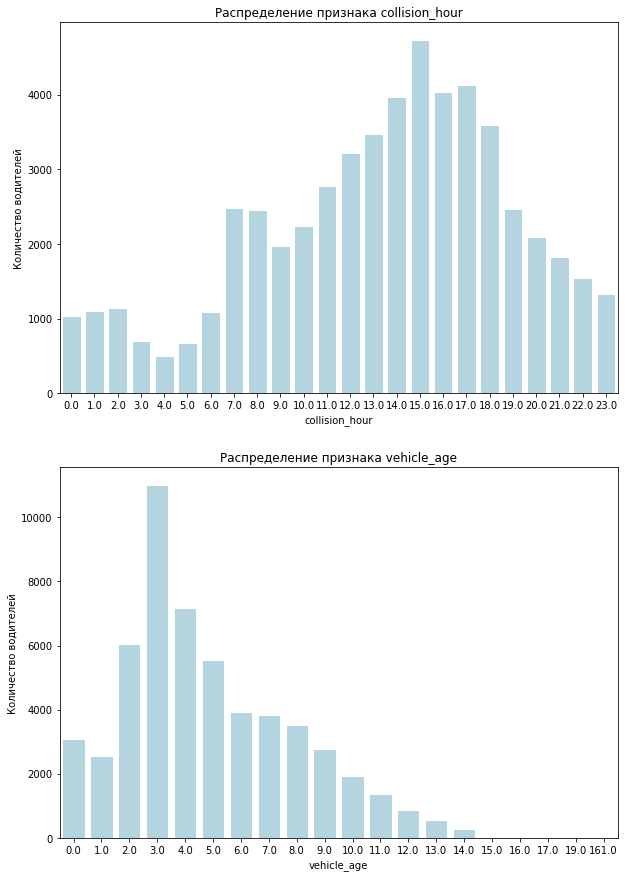

In [85]:
simplefilter(action='ignore', category=FutureWarning)

num_cols = ['collision_hour', 'vehicle_age']
display(data_1[num_cols].describe())
i=0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
axe = axes.ravel()
for col in num_cols:
    sns.set_style('whitegrid')
    sns.countplot(data_1[col], color='lightblue', ax=axe[i])
    axe[i].set_title(f'Распределение признака {col}')
    axe[i].set_xlabel(col)
    axe[i].set_ylabel('Количество водителей')
    i+=1

- В распределении ДТП по часам заметны 2 пика в начале и в конце рабочего дня. Это вполне логично, именно в это время дороги наиболее загружены.  
- Возраст большей части автомобилей в датасете составляет 3 года.
- В распределении возраста есть аномальный возраст авто 161 год, который мы уже видели ранее. Заменим его на 13 лет в тренировочном датасете (будем считать, что возраст автомобиля был указан в месяцах).

Проанализируем, как влияют значения количественных признаков на целевой at_fault.

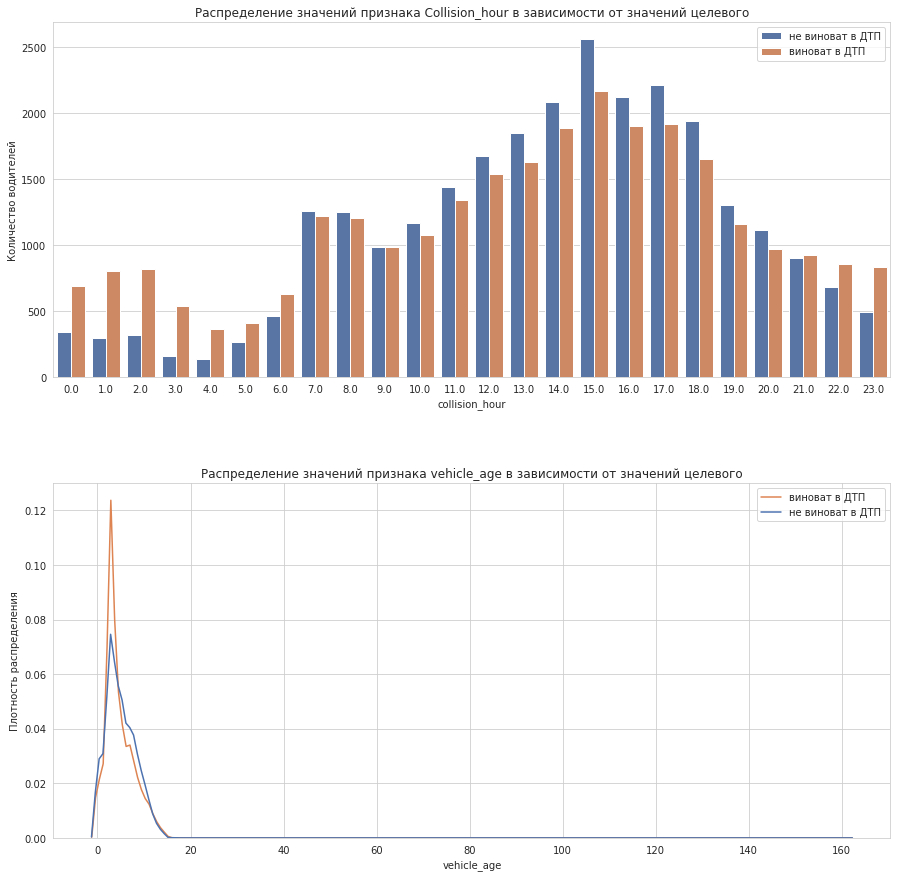

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axe = axes.ravel()
i=0
cols = ['collision_hour']
for col in cols:
    sns.countplot(x = col, hue = 'at_fault', palette='deep', data = data_1, orient='h', ax=axe[i])
    axe[i].set_title(f'Распределение значений признака {col.capitalize()} в зависимости от значений целевого')
    axe[i].set_ylabel('Количество водителей')
    axe[i].legend(['не виноват в ДТП', 'виноват в ДТП'])
    i+=1
sns.kdeplot(x = 'vehicle_age', hue = 'at_fault', palette='deep', data = data_1, ax=axe[i])
axe[i].set_title(f'Распределение значений признака vehicle_age в зависимости от значений целевого')
axe[i].set_ylabel('Плотность распределения')
axe[i].legend(['виноват в ДТП', 'не виноват в ДТП'])   
None

**Вывод**:

В ночное и утреннее время виновных водителей больше, возможно, из-за усталости или вождения в нетрезвом виде. 

Также чаще виновниками становятся владельцы автомобилей 1–4 лет, что может быть связано со стажем водителей или заводскими дефектами машин.

##### Категориальные признаки

Категориальных признаков у нас достаточно много. Посмотрим их распределение сразу в разрезе целевого - так мы сразу увидим и соотношение категорий и их влияние на целевой признак. Территорию использования авто проанализируем отдельно, в ней много уникальных категорий.

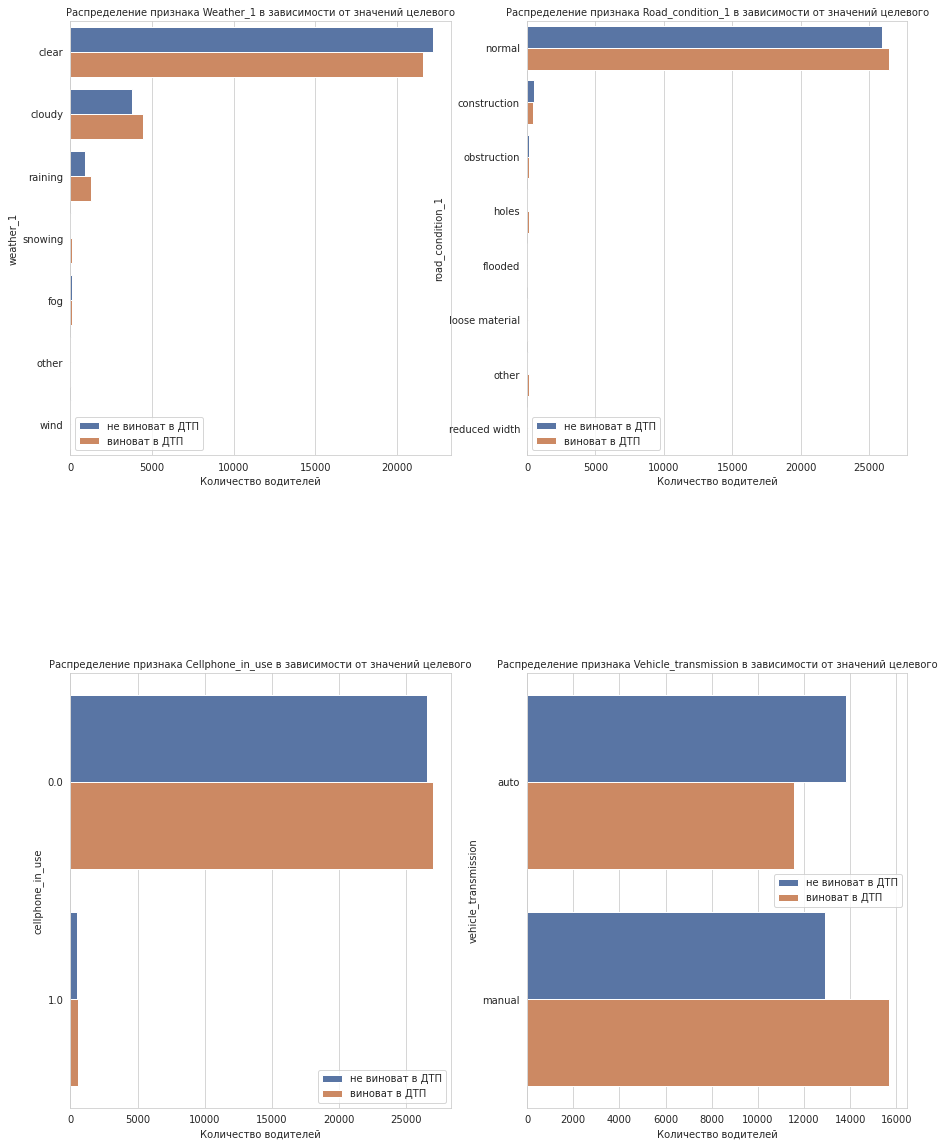

In [87]:
cat_cols = ['weather_1', 'road_condition_1', 'cellphone_in_use',
           'vehicle_transmission']
plt.rc('font', size=10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axe = axes.ravel()
i=0
for col in cat_cols:
    sns.countplot(y = col, hue = 'at_fault', data = data_1, palette='deep', orient='h', ax=axe[i])
    axe[i].set_title(f'Распределение признака {col.capitalize()} в зависимости от значений целевого', fontsize=10)
    axe[i].set_xlabel('Количество водителей')
    axe[i].legend(['не виноват в ДТП', 'виноват в ДТП'])
    i+=1

**Вывод**:
- В дождливую и облачную погоду водители чаще становятся виновниками ДТП, чем при хорошей погоде.
- Признак Road_condition1 распределен крайне неравномерно. Наибольшее количество значений признака соответствует нормальному состоянию дороги, и здесь количество виновников самое большое, остальные категории малочисленны. 
- Виновниками чаще становятся водителями, использующие автомобиль с механической коробкой передач.
- Чаще виновниками ДТП становятся люди, использующие телефон во время вождения автомобиля.

Проанализируем теперь территорию использования авто. Уникальных категорий в данном признаке достаточно много, поэтому выведем только топ-15 по количеству ДТП.

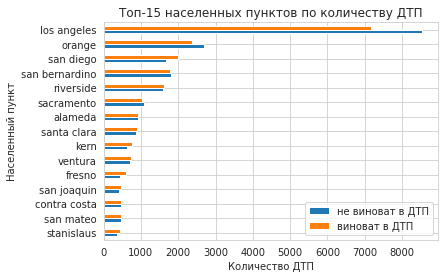

In [88]:
big_cat = data_1['county_location'].value_counts(ascending=False).head(15).reset_index()['index'].unique()
graf_data = pd.DataFrame({'не виноват в ДТП': data_1[(data_1['at_fault']==0) & (data_1['county_location'].isin(big_cat))]['county_location'] \
                          .value_counts(ascending=False).head(15),
                          'виноват в ДТП': data_1[(data_1['at_fault']==1) & (data_1['county_location'].isin(big_cat))]['county_location'] \
                          .value_counts(ascending=False).head(15)})
graf_data.sort_values(by='виноват в ДТП', ascending=True, inplace=True)
graf_data.plot.barh(title='Топ-15 населенных пунктов по количеству ДТП',  grid=True, rot=0)
plt.ylabel('Населенный пункт')
plt.xlabel('Количество ДТП')
plt.show()
None

**Вывод**: 
На графике видно, что для некоторых населенных пунктов, в которых происходит наибольшее количество ДТП, количество виновников превышает количество водителей, не виноватых в ДТП. В то же время в других доля аккуратных водителей выше. Следовательно данный признак можно использовать в модели.

Посмотрим теперь, как у нас распределены значения целевого признака at_fault.

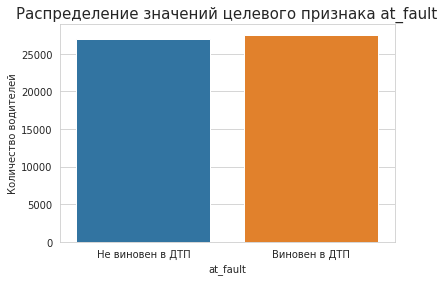

In [89]:
sns.countplot(x = 'at_fault', data = data_1)
plt.title('Распределение значений целевого признака at_fault', fontsize=15)
plt.xlabel('at_fault')
plt.xticks([0, 1],['Не виновен в ДТП', 'Виновен в ДТП'])
plt.ylabel('Количество водителей')
None

В датасете общее количество виновников чуть больше количества не виноватых в ДТП, однако доли примерно одинаковы. Это хорошо - нет дисбаланса в данных.

#### Матрица корреляции

Построим матрицу корреляции для определения силы взаимосвязи между признаками. Так как целевой у нас категориальный, используем коэффициент phik.
Для построения матрицы уберем выброс по значению возраста автомобиля

In [90]:
data_clean = data_1
data_clean .loc[data_clean['vehicle_age'] == 161, 'vehicle_age'] = 13

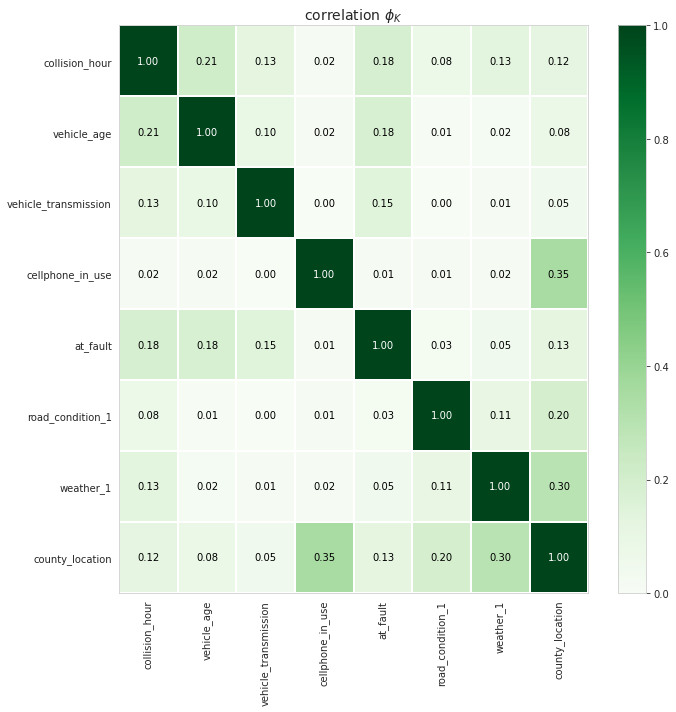

In [91]:
interval_cols = ['vehicle_age']

phik_overview = data_clean .phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='Greens', 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

**ВЫВОД**:
Согласно полученным данным и матрице корриляции мы можем сделать следующий вывод:


на целевой показатель (at_fault) оказывает влияние:
- 'collision_hour' - время происшествия
- 'vehicle_age' - возраст автомобиля
- 'vehicle_transmission' - тип коробки передач
- 'county_location' - район ДТП 

In [92]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54554 entries, 0 to 56247
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       54554 non-null  object 
 1   weather_1             54493 non-null  object 
 2   road_condition_1      54317 non-null  object 
 3   at_fault              54554 non-null  object 
 4   cellphone_in_use      54554 non-null  object 
 5   vehicle_transmission  53979 non-null  object 
 6   vehicle_age           54554 non-null  float64
 7   collision_hour        54551 non-null  float64
dtypes: float64(2), object(6)
memory usage: 5.8+ MB


Итоговый датасет состоит из 7 входных признаков.

#### Выделим тренировочную и тестовую выборки

In [93]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)


y_train = y_train.astype(int)
y_test = y_test.astype(int)

Предположим, что 161 - это возраст автомобиля в месяцах. В реальности, нужно было бы уточнить у тех, кто предоставил данные 

In [94]:
X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13

**Вывод**:

В результате обработки и фильтрации исходной базы данных был сформирован датасет, содержащий 56248 строк и 8 столбцов, основанный на информации о участниках ДТП, для которых имеются данные об обстоятельствах происшествий и автомобилях. Признак возраста автомобиля был учтен согласно требованиям заказчика, и для записей с отсутствующими значениями этого признака было удалено 3% данных, так как не было возможности логически заполнить пропуски. Несколько пропусков в других признаках были заполнены с учетом логики данных.

Анализ корреляции между признаками показал слабую взаимосвязь, коэффициенты корреляции варьируются в пределах от 0.01 до 0.18, что указывает на низкую линейную зависимость между переменными, однако не исключает возможного наличия нелинейных зависимостей. Датасет был разделен на обучающую и тестовую выборки в соотношении 70%/30%.

### Создание моделей для оценки вероятности ДТП. Выбор лучшей модели

#### Выбор метрики

В данной задаче основная цель системы — предупреждать водителя о высоком риске ДТП, то есть когда вероятность "at_fault" равна 1 (водитель виноват). Таким образом, важным аспектом является точность предупреждений при высоком риске, а также минимизация ложных тревог (когда система предупреждает о высоком риске, хотя на самом деле ДТП не произойдет).

**Для оценки модели можно рассмотреть несколько метрик:**

- Precision (точность) — покажет, насколько система точно предсказывает, что водитель будет виноват в ДТП, при этом минимизируя ложные срабатывания. Эта метрика важна, если нужно избегать чрезмерного количества ненужных предупреждений.

- Recall (полнота) — покажет, насколько система эффективно выявляет все случаи, когда водитель будет виноват. Высокий recall означает, что система предупреждает водителя всякий раз, когда это действительно нужно.

- F1-Score — сбалансированная метрика, которая учитывает и precision, и recall. Важно использовать её, если одинаково значимы и точность предсказаний, и способность выявлять все рисковые маршруты.

- ROC-AUC (Площадь под ROC-кривой) — эта метрика позволяет оценить, насколько хорошо модель различает классы "виноват" и "не виноват" по всему диапазону порогов. В данной задаче она может быть полезна, если важно адаптировать порог решения о риске в зависимости от условий (например, предпочтения водителя).

**Рекомендованная метрика:** В данной бизнес-задаче важен баланс между точностью и полнотой (чтобы предупреждать о риске, но не слишком часто и с минимальным упущением реальных случаев ДТП), поэтому будем использовать F1-Score. Это позволит избежать перекоса в сторону ложных срабатываний или упущения важных случаев риска.
Recall будем тоже сразу выводить, чтобы видеть, как работает модель.

Результаты всех решений сравним, выберем лучшее на основании значений f1 и recall.

#### DummyClassifier

Построим модель, котоая будет предсказывать значение при равной вероятности виновности или невиновнсоти в ДТП.
Данная модель будет использовала как ориентир, чтобы понимать нужность работы других моделей.
Метрики на дургих моделях должны быть лучше, иначе можно просто предсказывать среднее значенее.

In [95]:
cat_columns = ['weather_1', 'road_condition_1', 'cellphone_in_use', 'vehicle_transmission', 'county_location']
num_columns = ['collision_hour', 'vehicle_age']

cat_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))])

num_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('num', StandardScaler())])

data_preprocessor = ColumnTransformer(
    [('ohe', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)], remainder='passthrough')

dummy = Pipeline([('preprocessor', data_preprocessor),
                  ('models', DummyClassifier(random_state=RANDOM_STATE, strategy='uniform'))])

dummy.fit(X_train, y_train)
preds = dummy.predict(X_test)

dummy_f1 = round(f1_score(y_test, preds),2)
dummy_recall = round(recall_score(y_test, preds),2)

print('Значение dummy_f1: ', dummy_f1)
print('Значение dummy_recall: ', dummy_recall)

Значение dummy_f1:  0.5
Значение dummy_recall:  0.49


In [96]:
table = pd.DataFrame([['DummyClassifier', 'strategy=uniform', dummy_f1, dummy_recall]],
                    columns=['Model', 'Params', 'F1 Score', 'Recall Score'])
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.5,0.49


**Вывод**:

Базовые значения метрик получены - они соответствуют предсказанию, при котором у каждого класса равная вероятность.

#### DecisionTreeClassifier

In [97]:
simplefilter(action='ignore', category=UserWarning)

cat_columns = ['county_location',
             'weather_1',
             'road_condition_1',
             'cellphone_in_use',
             'vehicle_transmission']
num_columns = ['vehicle_age', 'collision_hour']


cat_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)) 
    ]
)

num_pipe = Pipeline(
    [
        ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
        ('num', StandardScaler())
    ]
)

In [98]:
data_preprocessor = ColumnTransformer(
    [('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# Получение количества признаков после обработки
n_features = X_train.shape[1]  # Количество признаков до препроцессинга


param_grid = {
    'models__max_depth': range(1, 20),
    'models__max_features': range(1, n_features + 1),  # Максимальное количество признаков
    'models__min_samples_leaf': range(1, 20)
}

dt = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=['f1', 'recall'],
    refit = 'f1',
    random_state=42,
    n_jobs=-1)

In [99]:
%time
dt.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan))]),
                                                                               ['county_location',


In [100]:
best_params_dt = dt.best_params_
f1_train_dt = round(dt.best_score_, 2)
recall_train_dt = round(dt.cv_results_['mean_test_recall'][dt.best_index_], 2)

print("Best parameters DecisionTreeClassifier: ", best_params_dt)
print("Best f1 DecisionTreeClassifier train: ", f1_train_dt)
print('Recall DecisionTreeClassifier train:', recall_train_dt)

Best parameters DecisionTreeClassifier:  {'models__min_samples_leaf': 8, 'models__max_features': 4, 'models__max_depth': 3}
Best f1 DecisionTreeClassifier train:  0.57
Recall DecisionTreeClassifier train: 0.59


In [101]:
table.loc[len(table.index )] = ['DecisionTreeClassifier', best_params_dt, f1_train_dt, recall_train_dt]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59


**Вывод**:

**Лучшие параметры:**

- models__min_samples_leaf: 11 — это минимальное количество выборок в листе дерева решений, что помогает избежать переобучения, гарантируя, что модель не будет слишком глубокой и переусложненной.
- models__max_features: 4 — это количество признаков, которое модель выбирает на каждом разбиении, что помогает улучшить предсказательную силу, ограничивая количество признаков, которые могут участвовать в каждом узле.
- models__max_depth: 4 — максимальная глубина дерева, что помогает увеличить его гибкость для учета сложных зависимостей в данных.

**Метрика качества:**

- F1-метрика на тренировочной выборке: 0.57 — это сбалансированная метрика, которая учитывает как полноту (recall), так и точность (precision). Значение 0.57 указывает на умеренный баланс между этими метриками, что приемлемо для данной модели.
- Recall на тренировочной выборке: 0.59 — это мера полноты, показывающая, что модель находит 59% всех положительных примеров, что является удовлетворительным результатом для задачи.

#### RandomForestClassifier

In [102]:
RANDOM_STATE = 42

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],  # целевой признак
    test_size=0.3, random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)

X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13

# Преобразование целевого признака в int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Преобразование категориальных признаков
categorical_columns = ['county_location',
             'weather_1',
             'road_condition_1',
             'cellphone_in_use',
             'vehicle_transmission']

# Числовые столбцы
num_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()


# Пайплайн для категориальных данных с использованием OrdinalEncoder
categorical_pipeline = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) 
    ]
)

# Пайплайн для числовых данных
numeric_pipeline = Pipeline(
    [
        ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
        ('scaler', StandardScaler())
    ]
)


# ColumnTransformer для комбинированной обработки данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_columns),
    ('cat', categorical_pipeline, categorical_columns)
])


# Определяем параметры для RandomizedSearchCV
params = {
    'classifier__n_estimators': [10, 20, 30, 100],
    'classifier__max_depth': [1, 3, 6, 10]
}

# Пайплайн для обучения модели
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# RandomizedSearchCV для оптимизации гиперпараметров
rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    cv=5,
    scoring=['f1', 'recall'],
    refit='f1',
    random_state=42,
    n_jobs=-1
)

# Запуск поиска лучших параметров
rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['vehicle_age',
                                                                                'collision_hour']),
                                                                              ('cat',
                                                                               Pi

In [103]:
# Получение лучших параметров и метрики
best_params_rf = rf.best_params_
f1_train_rf = round(rf.best_score_, 2)
recall_train_rf = round(rf.cv_results_['mean_test_recall'][rf.best_index_], 2)

print("Best parameters RandomForestClassifier found: ", best_params_rf)
print(f'RandomForestClassifier - F1 train Score: {f1_train_rf}')
print(f'RandomForestClassifier - Recall train Score: {recall_train_rf}')

Best parameters RandomForestClassifier found:  {'classifier__n_estimators': 10, 'classifier__max_depth': 6}
RandomForestClassifier - F1 train Score: 0.57
RandomForestClassifier - Recall train Score: 0.56


In [104]:
table.loc[len(table.index )] = ['RandomForestClassifier', best_params_rf, f1_train_rf, recall_train_rf]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59
2,RandomForestClassifier,"{'classifier__n_estimators': 10, 'classifier__...",0.57,0.56


**Лучшие параметры:**

- n_estimators: 10 – Это количество деревьев в ансамбле.
- max_depth: 6 – Максимальная глубина дерева. 

**Лучший F1 Score на кросс-валидации:**

Значение F1 Score на кросс-валидации составило 0.57. F1 Score – это гармоническое среднее между точностью (precision) и полнотой (recall), что делает его подходящим для несбалансированных данных. Значение 0.57 указывает на баланс между этими двумя метриками, однако, оно ниже 1, что означает, что модель все же допускает ошибки.

**Recall на тренировочных данных:**

Значение Recall на тренировочных данных составило 0.56. Это говорит о том, что модель правильно распознала примерно 57% всех истинно положительных примеров. Если это значение значительно отличается от Recall на тестовых данных, это может указывать на проблему переобучения или недообучения.

**Вывод:**
Текущие параметры дают умеренный результат.

#### CatBoost

In [105]:
RANDOM_STATE = 42

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],  # целевой признак
    test_size=0.3, random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)

# Преобразование категориальных признаков в строки
categorical_columns = ['county_location',
             'weather_1',
             'road_condition_1',
              'cellphone_in_use',
             'vehicle_transmission']

# Преобразование категориальных признаков в строки для X_train и X_test
X_train[categorical_columns] = X_train[categorical_columns].astype(str)
X_test[categorical_columns] = X_test[categorical_columns].astype(str)
    
X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13


# Преобразование целевого признака в int
y_train = y_train.astype(int)
y_test = y_test.astype(int)


# Определяем гиперпараметры для поиска
params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'depth': [4, 6, 8, 10]  
}


# Создание модели CatBoostClassifier
model_cat = CatBoostClassifier(
    cat_features=categorical_columns,  # Категориальные признаки
    random_seed=RANDOM_STATE,
    verbose=False  # Отключаем вывод прогресса
)

cat = RandomizedSearchCV(
    model_cat,
    param_distributions=params,
    cv=5,
    scoring=['f1', 'recall'],
    refit='f1',
    random_state=42,
    n_jobs=-1
)


# Запуск поиска лучших гиперпараметров
cat.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f436e125670>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, refit='f1', scoring=['f1', 'recall'])

In [106]:
best_params_cat = cat.best_params_
f1_train_cat = round(cat.best_score_, 2)
recall_train_cat = round(cat.cv_results_['mean_test_recall'][cat.best_index_], 2)

print("Best parameters found: ", best_params_cat)
print(f'CatBoost - F1 train Score: {f1_train_cat}')
print(f'CatBoost - Recall train Score: {recall_train_cat}')

Best parameters found:  {'n_estimators': 150, 'learning_rate': 0.1, 'depth': 6}
CatBoost - F1 train Score: 0.58
CatBoost - Recall train Score: 0.55


In [107]:
table.loc[len(table.index )] = ['CatBoostClassifier', best_params_cat, f1_train_cat, recall_train_cat]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59
2,RandomForestClassifier,"{'classifier__n_estimators': 10, 'classifier__...",0.57,0.56
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.55


**Вывод**:

**параметры для модели CatBoost следующие:**

- n_estimators (Количество деревьев): 150
- learning_rate (Темп обучения): 0.1
- depth (Глубина деревьев): 6

**Оценка модели на тренировочном наборе:**

- F1 Score: 0.58
- Recall (Полнота): 0.56

**Интерпретация результатов:**

- F1 Score измеряет баланс между точностью и полнотой, где значение 0.58 указывает на то, что модель довольно сбалансирована.

- Recall или полнота показывает, насколько хорошо модель идентифицирует положительные примеры. С результатом 0.55 можно заключить, что модель пропускает некоторые положительные случаи. 

Эти параметры дают умеренные результаты.

#### LightGBM

Изменим стратегию кодирования категориальных признаков. В бустинге есть внутренний кодировщик, воспользуемся им.  

Сначала заполним пропуски и масштабируем количественные признаки при помощи StandardScaler, а также поменяем тип в столбцах с категориальными признаками на category.

In [108]:
train_columns = X_train.columns
test_columns = X_test.columns

imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imp, columns = train_columns)
X_test = pd.DataFrame(X_test_imp, columns = test_columns)

num_cols = ['collision_hour', 'vehicle_age']
cat_cols = ['weather_1', 'county_location', 'road_condition_1', 'cellphone_in_use', 'vehicle_transmission']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)

X_train = pd.concat([X_train_scaled, X_train[cat_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[cat_cols]], axis=1)

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38187 entries, 0 to 38186
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   collision_hour        38187 non-null  float64 
 1   vehicle_age           38187 non-null  float64 
 2   weather_1             38187 non-null  category
 3   county_location       38187 non-null  category
 4   road_condition_1      38187 non-null  category
 5   cellphone_in_use      38187 non-null  category
 6   vehicle_transmission  38187 non-null  category
dtypes: category(5), float64(2)
memory usage: 786.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16367 entries, 0 to 16366
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   collision_hour        16367 non-null  float64 
 1   vehicle_age           16367 non-null  float64 
 2   weather_1             16367 non-null  category
 

In [109]:
model = LGBMClassifier(random_state = RANDOM_STATE, objective = 'binary')
param_grid = [
    {'n_estimators': [50, 100, 150],
     'learning_rate': [0.001, 0.01, 0.1]}]

model_lgb = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=5, 
    scoring=['f1', 'recall'],
    refit = 'f1',
    n_jobs=-1)

fit_params={'categorical_feature': 'auto'}
model_lgb.fit(X_train, y_train, **fit_params)

best_params_lgb = model_lgb.best_params_
f1_train_lgb = round(model_lgb.best_score_, 2)
recall_train_lgb = round(model_lgb.cv_results_['mean_test_recall'][model_lgb.best_index_], 2)

# Print the results
print('Лучшие параметры:', best_params_lgb)
print('Лучшее значение f1:', f1_train_lgb)
print('Лучшее значение recall:', recall_train_lgb)

Лучшие параметры: {'learning_rate': 0.001, 'n_estimators': 50}
Лучшее значение f1: 0.66
Лучшее значение recall: 0.83


In [110]:
table.loc[len(table.index )] = ['LGBMClassifier', best_params_lgb, f1_train_lgb, recall_train_lgb]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59
2,RandomForestClassifier,"{'classifier__n_estimators': 10, 'classifier__...",0.57,0.56
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.55
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.83


**Вывод**

**параметры для модели следующие:**

- n_estimators (Количество деревьев): 50
- learning_rate (Темп обучения): 0.001

- F1-мера (0.66): Это среднее гармоническое значение точности (precision) и полноты (recall). F1-мера показывает, насколько сбалансирована модель в плане минимизации ложных срабатываний и пропущенных событий. Значение 0.66 говорит о том, что модель демонстрирует умеренно хорошее качество предсказаний.

- Полнота (Recall) (0.83): Высокая полнота означает, что модель эффективно находит большинство случаев ДТП (правильно классифицирует позитивные примеры). Значение 0.83 указывает на то, что модель успешно идентифицирует 83% всех случаев ДТП в обучающей выборке, что довольно хорошо. Это говорит о способности модели минимизировать пропущенные случаи ДТП.


Модель настроена так, что она хорошо выявляет ДТП, поскольку полнота (Recall) довольно высокая. Это означает, что модель полезна в ситуациях, где важно минимизировать пропуски ДТП, даже если это означает некоторое количество ложных срабатываний.
Однако F1-мера на уровне 0.66 указывает на баланс между точностью и полнотой, и хотя модель успешно выявляет ДТП, есть вероятность, что точность может быть немного снижена.

### Результаты моделей

- Для предсказания целевого признака - виновности водителя в ДТП - были обучены несколько моделей (см таблицу ниже). 
- Качество модели оценивалось при помощи метрик f1 и recall.

Наилучший результат достигнут при использовании LGBMClassifier со скоростью обучения 0.001 и количеством деревьев 50. Данная модель лучше остальных определяет виновность водителя в ДТП, хоть и жертвует для этого невиновными водителями. 

Далее мы будем работать именно с этой моделью, на следующем этапе исследуем результаты ее предсказания.

In [111]:
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59
2,RandomForestClassifier,"{'classifier__n_estimators': 10, 'classifier__...",0.57,0.56
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.55
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.83


# Проверим лучшую модель в работе

In [112]:
preds = model_lgb.best_estimator_.predict(X_test)
print('Значение f1 на тестовых данных: ', round(f1_score(y_test, preds),2))
print('Значение recall на тестовых данных: ', round(recall_score(y_test, preds),2))
print('Значение precision на тестовых данных: ', round(precision_score(y_test, preds),2))

Значение f1 на тестовых данных:  0.66
Значение recall на тестовых данных:  0.86
Значение precision на тестовых данных:  0.53


**Интерпретация результатов:**
- F1-Score: 66 – это средневзвешенная метрика, которая учитывает и точность, и полноту. Значение 66 говорит о том, что модель сбалансированно оценивает ошибки обоих типов — как ложные срабатывания, так и пропуски ДТП.

- Recall (полнота): 86 – это доля истинных положительных событий (ДТП), которые модель правильно предсказала. То есть, модель смогла правильно выявить 86% всех случаев ДТП. Чем выше recall, тем меньше шансов, что модель пропустит потенциальное ДТП.

- Precision (точность): 53 – это доля событий, которые модель предсказала как ДТП, и которые на самом деле оказались ДТП. То есть, из всех предсказанных моделью случаев ДТП, только 53% действительно произошли.

**Вывод:**
- Модель LightGBM демонстрирует хорошую полноту (86%), что означает, что она хорошо справляется с выявлением случаев ДТП. Однако относительно невысокая точность (53%) говорит о том, что модель иногда ошибочно предсказывает ДТП, когда оно не происходит.
- F1-Score 66 указывает на то, что баланс между точностью и полнотой в модели приемлемый.

Построим матрицу ошибок

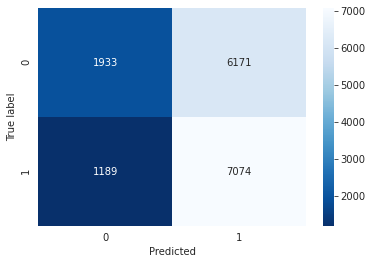

In [113]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

**Вывод:**
- True Negative (Истинно отрицательные): 1933 — это количество случаев, когда модель правильно предсказала, что ДТП не произойдет, и в реальности оно не произошло.
- True Positive (Истинно положительные): 7074 — это количество случаев, когда модель правильно предсказала, что ДТП произойдет, и в реальности оно действительно произошло.
- False Negative (Ложно отрицательные): 1189 — это количество случаев, когда модель предсказала, что ДТП не произойдет, но в реальности оно произошло.
- False Positive (Ложно положительные): 6171 — это количество случаев, когда модель предсказала, что ДТП произойдет, но в реальности оно не произошло.


- True Negative и True Positive показывают случаи, когда модель сработала корректно (правильные предсказания).
- False Negative — это те случаи, где модель не смогла распознать вероятность ДТП, что может быть опасно, так как авария произошла, но не была предсказана.
- False Positive — это те случаи, где модель предсказала аварию, но она не произошла. Такие ошибки могут быть нежелательны, но менее критичны, чем ложно отрицательные, поскольку они приводят к ложной тревоге, а не к пропуску реальной аварии.

**Выводы:**
- Модель достаточно хорошо предсказывает аварии (7074 истинных положительных случаев), но при этом допускает значительное количество ложных срабатываний (6171 случаев).
- Ложные отрицательные (1189) — важный показатель, который показывает, что модель не смогла правильно предсказать довольно много аварий. Этот тип ошибки может быть критичным, особенно в случае, если предотвратить их было возможно.
- Высокое количество ложных положительных ошибок может привести к избыточной осторожности или ненужным действиям, но такие ошибки менее опасны, чем ложные отрицательные.

# Проведем анализ важности факторов ДТП

Построим график и посмотрим, как признаки влияют на каждое предсказание модели:

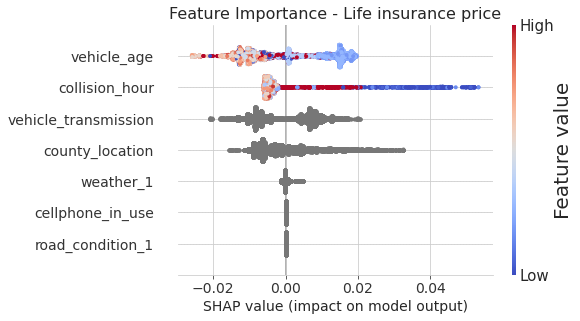

In [114]:
best_model_lgb = model_lgb.best_estimator_

explainer = shap.TreeExplainer(best_model_lgb)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Create a beeswarm plot for feature importance
shap.summary_plot(shap_values, X_test, cmap="coolwarm", show=False)

# Get the current figure and axes
fig, ax = plt.gcf(), plt.gca()

# Customize the main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_title('Feature Importance - Life insurance price', fontsize=16)

# Get the colorbar axis
cb_ax = fig.axes[1] 

# Customize the colorbar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Feature value", fontsize=20)

plt.show()

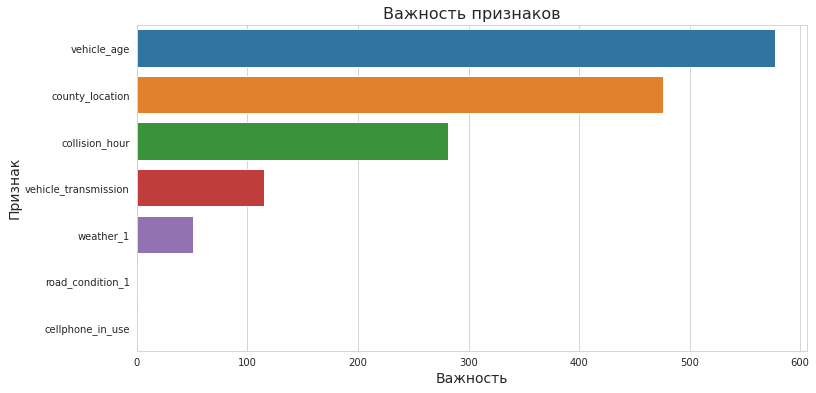

In [115]:
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                    'Importance': model_lgb.best_estimator_.feature_importances_})\
                      .sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()

Основное влияние на вероятность ДТП оказывают:

- возраст автомобиля
- территория использования транспортного средства
- час, в который совершается поездка. 

### Анализ важного фактора - возраста автомобиля

In [119]:
data_1.loc[data_1['vehicle_age'] == 161, 'vehicle_age'] = 13

pivot_data = data_1.pivot_table(index='vehicle_age', 
                                columns='at_fault', 
                                aggfunc='size', 
                                fill_value=0)

# Переименование столбцов для ясности
pivot_data.columns = ['Невиновен', 'Виновен']

# Сброс индекса для удобного отображения
pivot_data = pivot_data.reset_index()

print(pivot_data)

    vehicle_age  Невиновен  Виновен
0           0.0       1729     1358
1           1.0       1472     1073
2           2.0       2635     3413
3           3.0       4205     6807
4           4.0       3402     3755
5           5.0       2984     2581
6           6.0       2192     1748
7           7.0       2095     1743
8           8.0       2047     1462
9           9.0       1582     1188
10         10.0       1115      827
11         11.0        733      647
12         12.0        436      443
13         13.0        253      300
14         14.0        120      162
15         15.0          8       29
16         16.0          4        2
17         17.0          1        2
18         19.0          0        1


<Figure size 720x432 with 0 Axes>

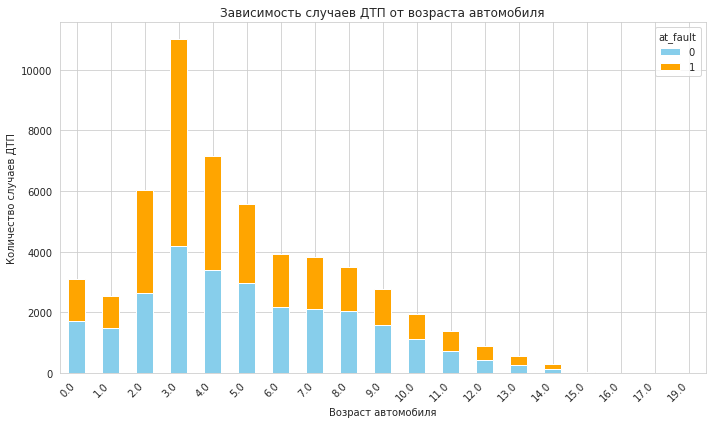

In [120]:
data_1.loc[data_1['vehicle_age'] == 161, 'vehicle_age'] = 13

sobriety_fault_counts = data_1.groupby(['vehicle_age', 'at_fault']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sobriety_fault_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])

plt.xticks(rotation=45, ha='right')
plt.xlabel('Возраст автомобиля')
plt.ylabel('Количество случаев ДТП')
plt.title('Зависимость случаев ДТП от возраста автомобиля')
plt.legend(title='at_fault', loc='upper right')
plt.tight_layout()
plt.show()

**Вывод:**
- Новые автомобили (0–2 года):

У транспортных средств возрастом до 2 лет количество невиновных водителей больше, чем виновных.

- Автомобили 3-5 лет:

В этих возрастных категориях наблюдается рост числа виновных случаев, особенно для 3-летних машин, где количество виновных превышает количество невиновных.

- Автомобили 6-10 лет:

Начиная с 6 лет, количество виновных случаев постепенно снижается, однако их количество остаётся сопоставимым с числом невиновных.
Это может быть связано с износом автомобиля, но также может говорить о том, что водители старых автомобилей более осторожны.

- Старые автомобили (более 10 лет):

У автомобилей возрастом более 10 лет наблюдается устойчивая тенденция к снижению как количества виновных, так и невиновных водителей.
Наиболее вероятно, что старые автомобили реже используются, поэтому количество ДТП среди них меньше.

- Очень старые автомобили (15+ лет):

В этих категориях количество случаев падает почти до нуля. Это может означать, что такие автомобили становятся редкостью на дорогах или используются очень ограниченно.

**Выводы и рекомендации:**
- Снижение количества ДТП среди новых автомобилей может свидетельствовать о том, что новыми автомобилями, вероятно, управляют более аккуратные водители или они оснащены более современными системами безопасности.
- Пик виновных случаев приходится на автомобили возрастом 3-5 лет, что может свидетельствовать о начале износа машины и о том, что такие автомобили находятся в активном использовании. Рекомендуется уделить внимание водителям этих категорий для профилактики ДТП.
- Снижение числа случаев у старых автомобилей может быть связано с ограниченным использованием этих транспортных средств или с тем, что ими управляют более осторожные водители. Однако состояние таких машин требует контроля, чтобы снизить риск аварий по техническим причинам.

### Анализ важного фактора - country location

Проведем дополнительное исследование влияния территории на виновность водителя. Ранее, на этапе исследовательского анализа, мы смотрели топ-15 самых аварийных городов в разрезе виновности водителей. Из этого топа возьмем 3 города, в которых количество виновников превышает количество невиновных водителей, также возьмем причины ДТП для виновников. 

In [116]:
graf_data = pd.DataFrame(graf_data)

cities = graf_data[graf_data['виноват в ДТП'] > graf_data['не виноват в ДТП']]\
        .sort_values(by='виноват в ДТП', ascending=False).head(3)
cities

,не виноват в ДТП,виноват в ДТП
san diego,1679,1996
riverside,1598,1607
santa clara,872,907


In [117]:
# Фильтруем строки по нужным городам
cities_to_select = ['san diego', 'riverside', 'santa clara']
filtered_data = data_2[data_2['county_location'].isin(cities_to_select)]

# Оставляем только нужные столбцы
filtered_data = filtered_data[['at_fault', 'county_location', 'pcf_violation_category']]
# Оставляем только те строки, где столбец 'at_fault' равен 1
filtered_data = filtered_data[filtered_data['at_fault'] == 1]

# Удалим строки без причины ДТП
filtered_data = filtered_data.dropna(subset=['pcf_violation_category'])
filtered_data = filtered_data.drop('at_fault', axis=1)
# Выводим информацию о DataFrame
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4572 entries, 36 to 56246
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   county_location         4572 non-null   object
 1   pcf_violation_category  4572 non-null   object
dtypes: object(2)
memory usage: 107.2+ KB


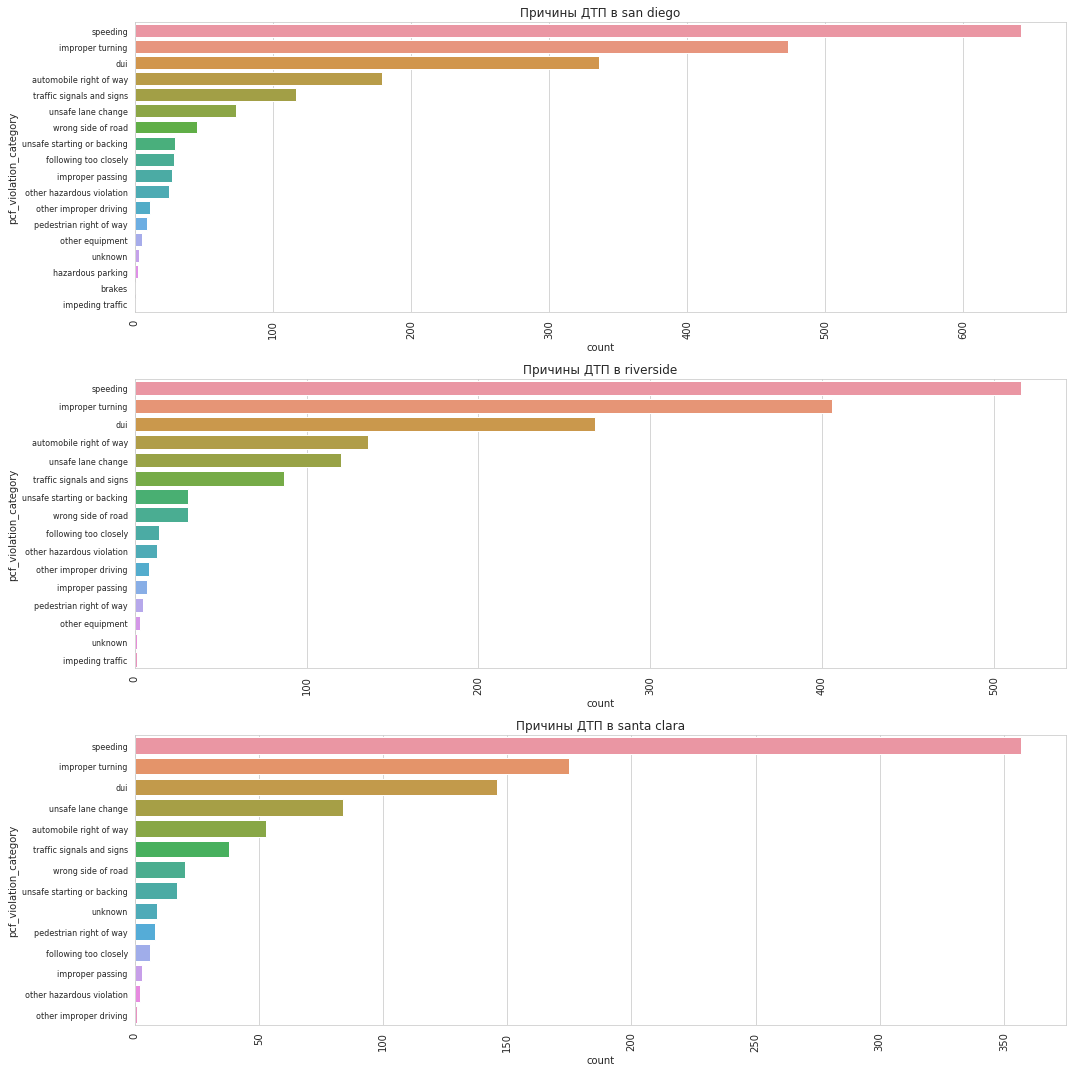

In [118]:
# Группируем данные по 'county_location' и 'pcf_violation_category' и считаем количество
grouped_data = filtered_data.groupby(['county_location', 'pcf_violation_category']).size().reset_index(name='count')

# Сортировка данных по убыванию количества
grouped_data = grouped_data.sort_values(by='count', ascending=False)

# Создание графиков для каждого города
unique_cities = grouped_data['county_location'].unique()

# Установим размер графиков
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Создадим графики для каждого города
for i, city in enumerate(unique_cities):
    plt.subplot(len(unique_cities), 1, i+1)
    city_data = grouped_data[grouped_data['county_location'] == city]
    sns.barplot(y='pcf_violation_category', x='count', data=city_data)
    plt.title(f'Причины ДТП в {city}')
    plt.xticks(rotation=90)
    plt.yticks(fontsize=8)

# Подгоняем расположение графиков
plt.tight_layout()
plt.show()

В 3 городах с наибольшим количеством ДТП при наибольшей доле виновников самые распространенные причины ДТП совпадают. Это:  
1. Нарушение скоростного режима.  
2. Нарушение правил поворота.  
3. Вождение автомобиля под воздействием алкоголя/препаратов (dui расшифровывается как Driving under the influence).  

Таким образом, для уменьшения риска попадания в ДТП я предложил бы следующее.  
- установить на автомобили ограничители скорости, что не позволит нарушать скоростной режим. Лимит скорости на ограничители может передаваться с навигатора.  
- оборудовать автомобили удобным навигатором, на котором видны знаки поворотов на ближайших перекрестках.    
- оснастить автомобили анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль.

# Выводы

Нашей задачей была разработка модели для определения вероятности ДТП.

У заказчика были определенные требования к алгоритму:

1. Тип виновника — только машина (car).
2. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
3. Ограничиться данными за 2012 год.
4. Учесть фактор возраста автомобиля.

Для решения указанной задачи была предоставлена база данных, содержащая информацию о ДТП, участниках ДТП и их автомобилях за несколько лет.  


**Факторы, влияющие на количество и виновность в ДТП**

- Наибольшее количество ДТП приходится на период с января по май. Скорее всего это связано с трудными погодными условиями - дороги занесены снегом. В июне аварийность резко падает, затем постепенно растет к осени. Обнаружны 2 пика происшествий - в марте и в октябре. Это переходные месяцы между зимним и летним сезонами.

- Автомобили с возрастом около 3 лет могут столкнуться с рядом проблем, таких как снижение внимательности владельцев, увеличение пробега, смена владельцев, потеря заводских настроек и износ ключевых компонентов. Эти факторы, в совокупности с возможными неисправностями из-за некачественного ремонта, могут негативно повлиять на безопасность автомобиля и повысить риск аварий.

- Аварии чаще происходят на сухих дорогах, что свидетельствует о том, что безопасность водителей не зависит только от состояния покрытия. Мокрые и скользкие дороги, хотя и реже, представляют повышенную опасность. Снежные и скользкие покрытия вызывают меньше аварий, вероятно, из-за сезонных условий и ограниченного использования дорог.

- Ясная и облачная погода связаны с меньшими летальными исходами и повреждениями, в то время как туман, дождь и ветер увеличивают риск серьезных аварий. Снег и туман повышают риски, особенно для тяжелых происшествий. 

- В распределении часов в зависимости от вины водителя видна закономерность - количество виновников превышает количество невиновных в ночное время и ранним утром. Возможно, это связано с ездой в нетрезвом виде и состоянии усталости.

- В темное время суток вероятность стать виновником ДТП выше, чем в дневное время. На рассвете и на закате количество виновных и не виновных в ДТП водителей примерно одинаковое.  

Также после работы с моделями обнаружена сильная нелинейная взаимосвязь между городом использования авто и виновностью в ДТП. В связи с этим проведен анализ причин виновности в ДТП в городах с самых большей долей виновников среди городов с самым большим количесвтом ДТП. Выявлены 3 основные причины виновности в ДТП:  

1. Нарушение скоростного режима.
2. Нарушение правил поворота.
3. Вождение автомобиля под воздействием алкоголя/препаратов.  

**Рекомендации по снижению вероятности ДТП**  

Исходя из результатов анализа мы предлагаем 3 рекомендации, направленные на снижение вероятности ДТП.  
- установить на автомобили ограничители скорости, что не позволит нарушать скоростной режим. Лимит скорости на ограничители может передаваться с навигатора.
- оборудовать автомобили удобным навигатором, на котором видны знаки поворотов на ближайших перекрестках.
- оснастить автомобили анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль.

**Датасет, использованный для построения модели**  

Итоговый датасет состоял из 7входных признаков.  

county_location - территория использования автомобиля.  
weather_1 - погодные условия
road_condition_1 - состояние дорожного покрытия
cellphone_in_use - использование мобильного телефона
vehicle_transmission - тип коробки передач.  
vehicle_age - возраст авто. 
collision_hour - час, в который совершается поездка.

Все остальные признаки либо совсем не оказывали влияние на целевой, либо дублировали отобранные, либо являлись характеристикой последствий ДТП.  

**Модель для предсказания значений целевого признака**  

Для предсказания виновности водителя в ДТП - были построены несколько моделей. Качество модели оценивалось при помощи метрик f1 и recall. Для каждой модели осуществлен перебор ряда гиперпараметров. Также в качестве базового решения был использован DummyClassifier с настройкой, при которой оба оба класса целевого признака имели равную вероятность стать результатом прогноза. То есть получилось случайное предсказание. Все модели сравнивались с этим базовым решением.

Наилучший результат достигнут при использовании LGBMClassifier со скоростью обучения 0.001 и количеством деревьев 50. У данной модель есть большой плюс - она хорошо распознает потенциальных виновников ДТП, но в то же время и присутствует минус - многим невиновным модель спрогнозировала виновность в ДТП. Результаты всех моделей приведены в таблице ниже.

**Вывод:**
- Модель LightGBM демонстрирует хорошую полноту (83%), что означает, что она хорошо справляется с выявлением случаев ДТП. Однако относительно невысокая точность (53%) говорит о том, что модель иногда ошибочно предсказывает ДТП, когда оно не происходит.
- F1-Score 66 указывает на то, что баланс между точностью и полнотой в модели приемлемый.

Данная конфигурация модели LightGBM продемонстрировала сбалансированные показатели точности и полноты, что указывает на удовлетворительное качество предсказаний.

In [121]:
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 8, 'models__max_f...",0.57,0.59
2,RandomForestClassifier,"{'classifier__n_estimators': 10, 'classifier__...",0.57,0.56
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.55
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.83


**Рекомендации:**

- Стаж вождения: учитывать опыт водителя при анализе аварийности и принятии решений, так как опыт может напрямую влиять на вероятность ДТП.

- Проверка трезвости: внедрить системы проверки состояния водителя с помощью датчиков, чтобы каждый раз перед началом поездки водитель дышал в трубку, подтверждая отсутствие алкогольного опьянения.

- База данных ДТП: создать единую базу данных, привязанную к номеру водительского удостоверения, где фиксируются все инциденты. Это позволит отслеживать историю водителя и принимать соответствующие меры.

- Алкогольное опьянение: несмотря на то, что алкоголь не является единственной причиной ДТП, тяжесть аварий при участии нетрезвых водителей обычно выше. Поэтому особое внимание следует уделять предотвращению управления автомобилем в состоянии алкогольного опьянения.

- Возраст автомобиля: учитывать возраст транспортного средства при оценке его технического состояния. Регулярное обслуживание и своевременная замена шин в зависимости от сезона также являются важными факторами безопасности.

- Неполные данные: текущие данные охватывают в основном период с января по май 2012 года, что может значительно искажать общую картину анализа. Для более точных выводов необходимо собрать и учитывать данные за другие месяцы года.